# BNS merger and disk formation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from os import listdir
from scipy.optimize import fsolve
from matplotlib import rc

In [2]:
LNWDT=1.4; FNT=18
plt.rcParams['lines.linewidth'] = LNWDT; plt.rcParams['font.size'] = FNT
plt.rcParams['xtick.direction'] = 'in'; plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'on'; plt.rcParams['ytick.right'] = 'on'
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['font.family'] = 'Times New Roman'
rc('mathtext', fontset='stix')

In [3]:
#-- CONSTANTS
# speed of light:
clight = 2.99792458e8                # m/s
#clight = 3.0e8
# Newton's gravitational constant
G = 6.67259e-11                      # m^3/kg/s^2 
# one parsec, popular unit of astronomical distance (around 3.26 light years)
parsec = 3.08568025e16               # m
# solar mass
MSol = 1.989e30                      # kg
# solar mass in seconds (isn't relativity fun?):
tSol = MSol*G/np.power(clight,3)     # s

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# Reading Data

In [4]:
## Reading files ###
#mypath = '/home/jose/Dropbox/CAS/mathworks/GW/Damour/Data/'
mypath = '/Users/jose/Dropbox/CAS/mathworks/GW/Damour/Data/'
filenames = np.sort(listdir(mypath))
R_data = {}
M_data = {}
for i in np.arange(0, len(filenames)):
    R_data['{0}'.format(filenames[i])]=np.loadtxt(mypath+filenames[i])[:,0]
    M_data['{0}'.format(filenames[i])]=np.loadtxt(mypath+filenames[i])[:,1]
print (filenames)
Compact = {}
for i in np.arange(1,len(filenames),2):
     Compact[filenames[i][11:-4]] = clight*tSol*M_data[filenames[i]]/(R_data[filenames[i]]*1.e3)
# Keplerian sequence
Mass_Keplerian = np.loadtxt('keplerian.txt')[:,1]
J_Keplerian = np.loadtxt('keplerian.txt')[:,7]
M_j_kep_interp = interp1d(J_Keplerian, Mass_Keplerian)

['MassRadius_GM1G.dat' 'MassRadius_GM1L.dat' 'MassRadius_NL3G.dat'
 'MassRadius_NL3L.dat' 'MassRadius_TM1G.dat' 'MassRadius_TM1L.dat'
 'NSNS_Opt.txt']


# Functions and SE

The angular mometum of the newly formed NS is calculated asuming that the angular momentum per mass of a test particles is $ J_{\rm{cont}}/m_p = 2 m_{NS} \mathcal{C}^{-1/2}$

In [5]:
##########################
#     L LSO function
##########################

def L_LSOfunc(m, j):
    return m*(2*np.sqrt(3.) - 0.37*(j/m)**0.85)

#################################
# This function calculates
# the critical angular momentum
# of the newly formed NS i.e.
# when the L_LSO = L_contact
#################################

def jfunc(mNS, mnNS, Comp):
    m = 2*mNS
    l = m*Comp**(-0.5)
    A = 2*np.sqrt(3) - l/mnNS
    return mnNS*(A/0.37)**(1/0.85)

#############################
#     Initial mass
#############################

def mass_i(mNS, Comp):
    return 2*mNS/(2*np.sqrt(3)*Comp**0.5)

########################
# Principal equation for 
# solving the system
#######################

def massfunc(m, j):
    return m + 13/200.*m**2*(1 - j**1.7/130.)

########################################

def mass_eq(mNS, mnNS, Comp):
    j = jfunc(mNS, mnNS, Comp)
    A = 2*(mNS + 13/200.*mNS**2)
    B = mnNS + 13/200.*mnNS**2*(1 - j**1.7/130.)
    return A - B

def massnNS(mNS,Comp):
    def eq(mnNS):
        return mass_eq(mNS, mnNS, Comp)
    return fsolve(eq, 1.9*mNS)[0]

########################################
def massnNS_j(m_init, j, m_lost=0):
    def eq(m_final):
        A = 2*massfunc(m_init, 0)
        B = massfunc(m_final, j)
        return A - m_lost - B # m_lost is the baryonic mass of the ejecta and the disk
    return fsolve(eq, 1.9*m_init)[0]

def massnNS_keplerian(m_init, m_other=0, j_kep=0.7):
    def eq(m_final):
        A = 2*massfunc(m_init, 0)
        B = m_final + 13/200.*m_final**2*(1 - j_kep**1.7*m_final**3.4/130.)
        return  A - m_other - B  # m_lost is the baryonic mass of the ejecta and the disk
    return fsolve(eq, 2*m_init)[0]

def massnNS_keplerian_from_q(m_tot, q, m_other=0.0, j_kep=0.7):
    """Return the core mass of the SMNS given the total mass and q=m2/m1 < 1"""
    def eq(m_final):
        m1 = m_tot/(1 + q)
        m2 = m_tot*q/(1 + q)
        A = massfunc(m1, 0) + massfunc(m2, 0)
        B = m_final + 13/200.*m_final**2*(1 - j_kep**1.7*m_final**3.4/130.)
        return  A - B - m_other  # A = B + m_other
    return fsolve(eq, m_tot)[0]

def ratio_func(m_init, Comp, j):
    mNS = massnNS_j(m_init, j)
    lLSO = L_LSOfunc(mNS, j)
    l_contact =  m_init*Comp**(-0.5)
    return lLSO/l_contact

###### Compacteness function #########
#       for NL3 Local 
#########################################

compactness_inter = interp1d(M_data[filenames[3]],Compact['NL3L'])
compactness_interNL3L = interp1d(M_data[filenames[3]],Compact['NL3L'])
compactness_interGM1L = interp1d(M_data[filenames[1]],Compact['GM1L'])
compactness_interTM1L = interp1d(M_data[filenames[5]],Compact['TM1L'])

########################################
# ratio lLSO to lcontact as a function
# of the j/MnNS**2
########################################

def m_final_func_a(m_init, a):
    def eq(m_final):
        A = 2*massfunc(m_init, 0) # symmetric system
        B = massfunc(m_final, a*m_final**2) 
        #B = m_final + 13/200.*m_final**2*(1 - 1/130.*(a*m_final**2)**1.7)
        return A - B
    return fsolve(eq, 1.8*m_init)[0]

def ratio_func_a(m_init, a):
    compactness = compactness_inter(m_init)
    m_final = m_final_func_a(m_init, a)
    j = a*m_final**2
    lLSO = L_LSOfunc(m_final, j)
    l_contact =  2*m_init*compactness**(-0.5)
    return [lLSO/l_contact, j, m_final] 

def m_crit_kep(M0, k, p):
    def my_func(M):
        return M0*(1 + k*(0.70*M**2)**p) - M
    y = fsolve(my_func, M0)[0]
    return y

def l_max_from_mtotqC1C2(mtot,q, C1, C2):
    return mtot*np.sqrt( (C2+q*C1) / ((1+q)*C1*C2) )

In [6]:
m_NS = 1.36
compNS = np.array([ compactness_interNL3L(m_NS) , compactness_interGM1L(m_NS) , compactness_interTM1L(m_NS) ])
print (compNS)
print ('{0:.2f} {1:.2f} {2:.2f}'.format(*((compNS**(1.5)/tSol/(2*m_NS)/np.pi).tolist())))
print ('{0:.2f} {1:.2f} {2:.2f}'.format(*((1.336*m_NS**2*compNS**(-0.5)).tolist())))
print (2*m_NS*compNS**-.5)
                            

[ 0.135  0.143  0.139]
1183.54 1291.25 1227.13
6.72 6.52 6.64
[ 7.392  7.181  7.304]


In [7]:
idx = np.where(M_data[filenames[3]]<1.45)
R_data[filenames[3]][idx][-1]

14.83790088

In [8]:
compactness_interGM1L(1.33)

array( 0.140)

# Mass vs Radius

In [9]:
mi = np.max(M_data['MassRadius_NL3L.dat'])

print (mi)
print (compactness_inter(mi))
print (mi*compactness_inter(mi)**(-.5))
print (mi/compactness_inter(mi)*1.477)
m_remn = 2.6
print ('Mass = {0:.2f} comp = {1:}'.format(m_remn, compactness_inter(m_remn)))

2.806906284
0.30740960190248573
5.062548519790616
13.48624296642205
Mass = 2.60 comp = 0.26640622467021285


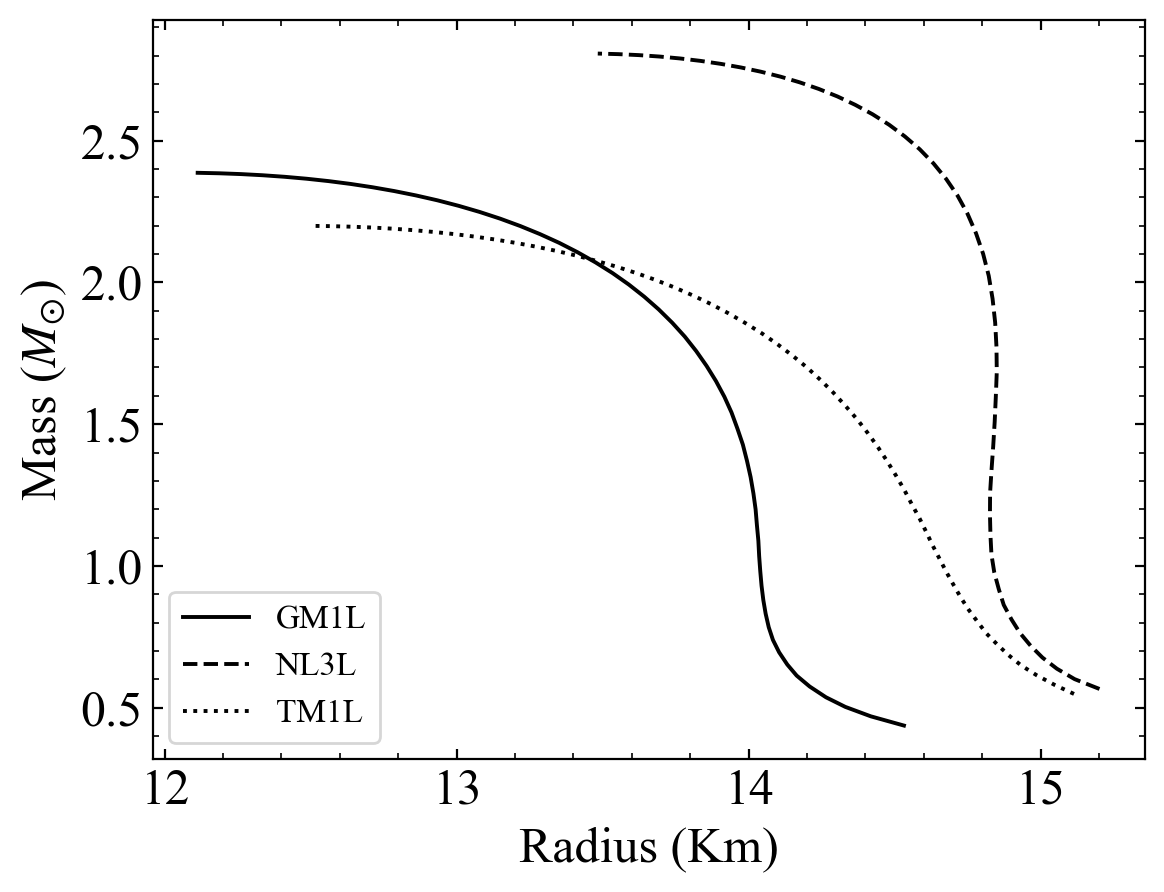

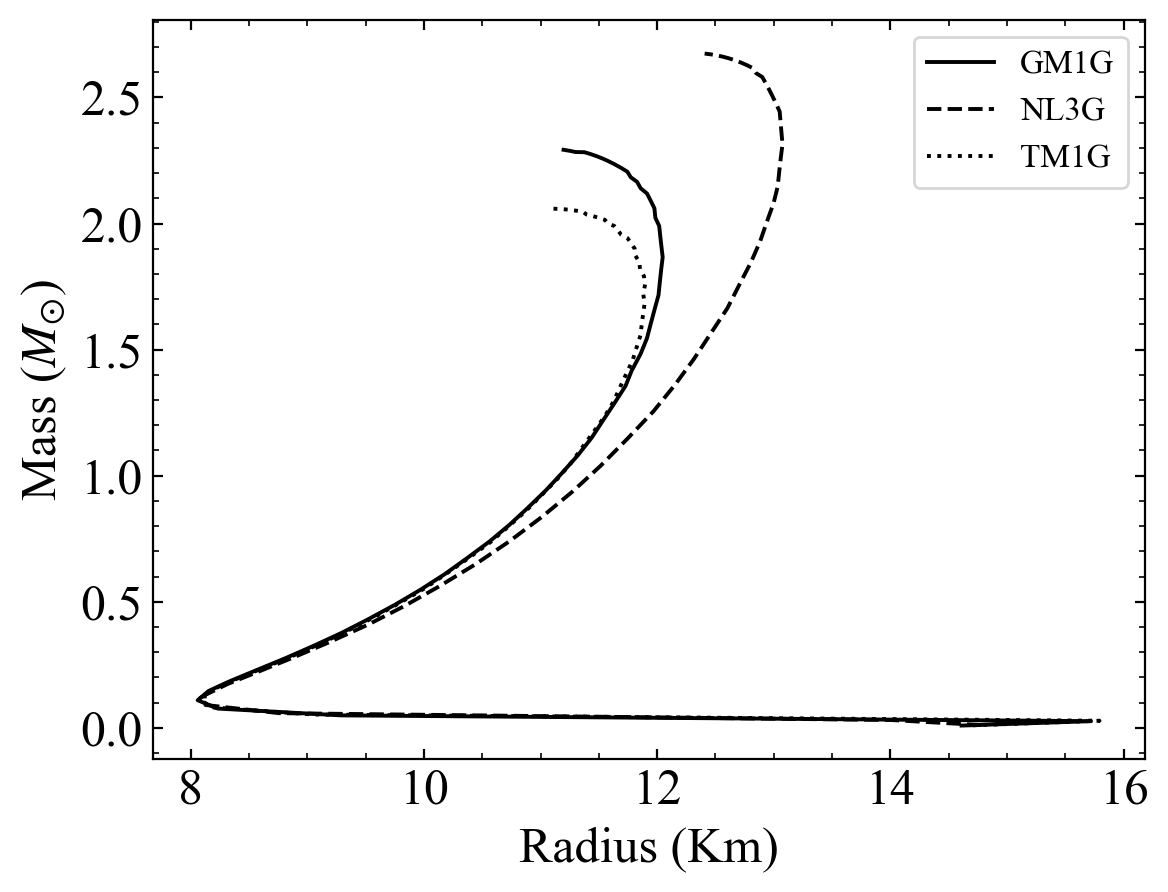

In [10]:
line_style = ['-','--',':']
########## LOCAL #############
plt.figure()
for i in np.arange(1,len(filenames),2):
    plt.plot(R_data[filenames[i]], M_data[filenames[i]], label=filenames[i][11:-4], 
             color='k', linestyle=line_style[int((i)/2)])
plt.legend(loc='lower left',  fontsize=12)
plt.xlabel('Radius (Km)')
plt.ylabel(r'Mass ($M_{\odot}$)')
plt.savefig('M-R_local.pdf')
######### GlOBAL #############
plt.figure()
for i in np.arange(0,len(filenames)-1,2):
    plt.plot(R_data[filenames[i]], M_data[filenames[i]], label=filenames[i][11:-4],
            color='k', linestyle=line_style[int((i)/2)])
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Radius (Km)')
plt.ylabel(r'Mass ($M_{\odot}$)')
plt.savefig('M-R_global.pdf')


# Compactness

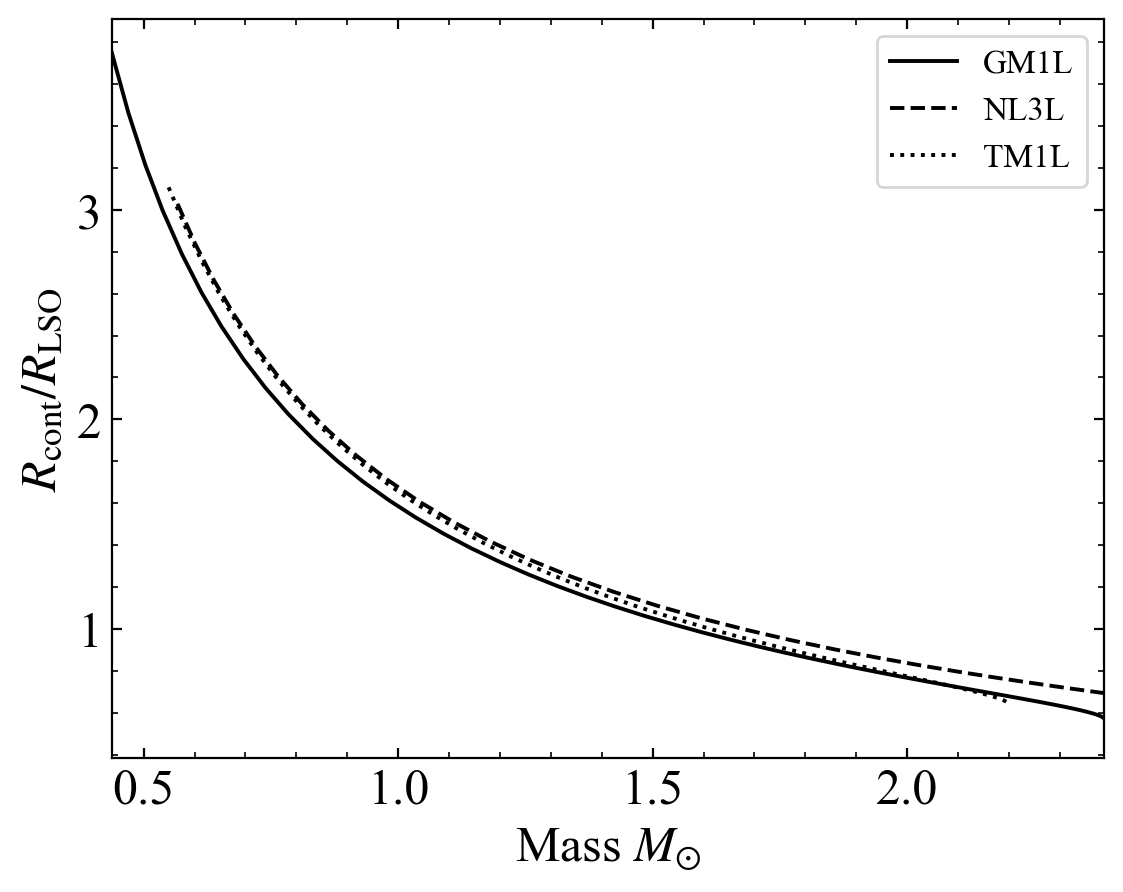

In [11]:
plt.figure()
for i in np.arange(1,len(filenames),2):
    plt.plot(M_data[filenames[i]], R_data[filenames[i]]*1e3/(6*tSol*clight*M_data[filenames[i]]),
             label=filenames[i][11:-4], color='k', linestyle=line_style[int((i)/2)])
#plt.plot([M_data[filenames[1]][0],3],[1,1], 'k', dashes=[5,5])
plt.xlim([M_data[filenames[1]][0], M_data[filenames[1]][-1]])
plt.xlabel(r'Mass $M_{\odot}$')
plt.ylabel(r'$R_{\rm{cont}}/R_{\rm{LSO}}$')
plt.legend(loc='upper right', fontsize=12)
plt.savefig('Rcont-Rlso.pdf', bbox_inches='tight')

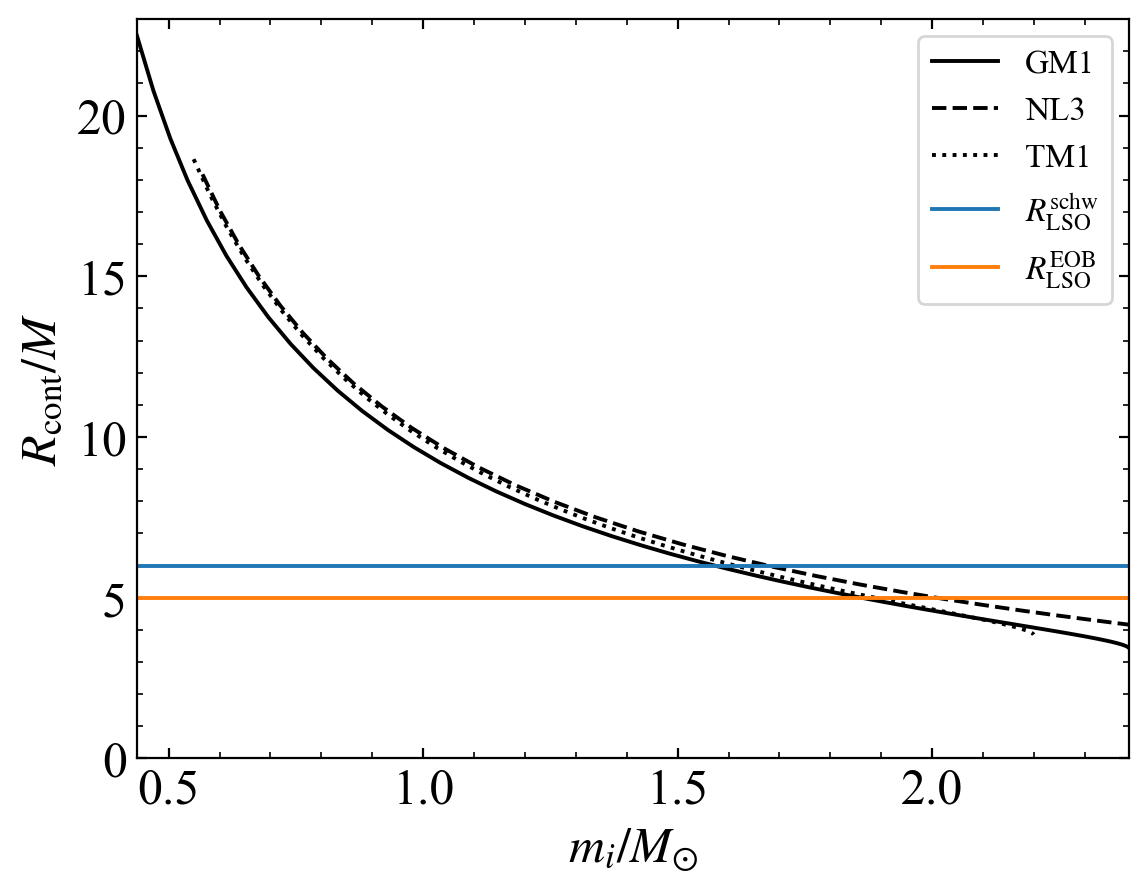

In [12]:
plt.figure()
for i in np.arange(1,len(filenames),2):
    plt.plot(M_data[filenames[i]], R_data[filenames[i]]*1e3/(tSol*clight*M_data[filenames[i]]),
             label=filenames[i][11:-5], color='k', linestyle=line_style[int((i)/2)])
plt.plot([M_data[filenames[1]][0],3],[6,6],'C0', label=r'$R_{\rm{LSO}}^{\rm{schw}}$')
plt.plot([M_data[filenames[1]][0],3],[5,5],'C1', label=r'$R_{\rm{LSO}}^{\rm{EOB}}$')
plt.xlim([M_data[filenames[1]][0], M_data[filenames[1]][-1]])
plt.xlabel(r'$m_i/M_{\odot}$')
plt.ylabel(r'$R_{\rm{cont}}/M$')
plt.legend(loc='upper right', fontsize=12)
plt.ylim([0,23])
plt.savefig('Rcont-Mass.pdf')

Therefore, when the mass of the sysmtem is greater than $\approx 1.86\ M_{\odot}$, it proceed to a plunge phase. Below this limit mass the plunged is not present.

In [13]:
for i in np.arange(1,len(filenames),2):
    interR_Rlso1 = interp1d(M_data[filenames[i]], R_data[filenames[i]]*1e3/(5*tSol*clight*M_data[filenames[i]])-np.ones(len(M_data[filenames[i]])))
    print (filenames[i][11:-4])#, fsolve(interR_Rlso1, 1.7)

GM1L
NL3L
TM1L


Next we'll calculate the compactness for the different EOS

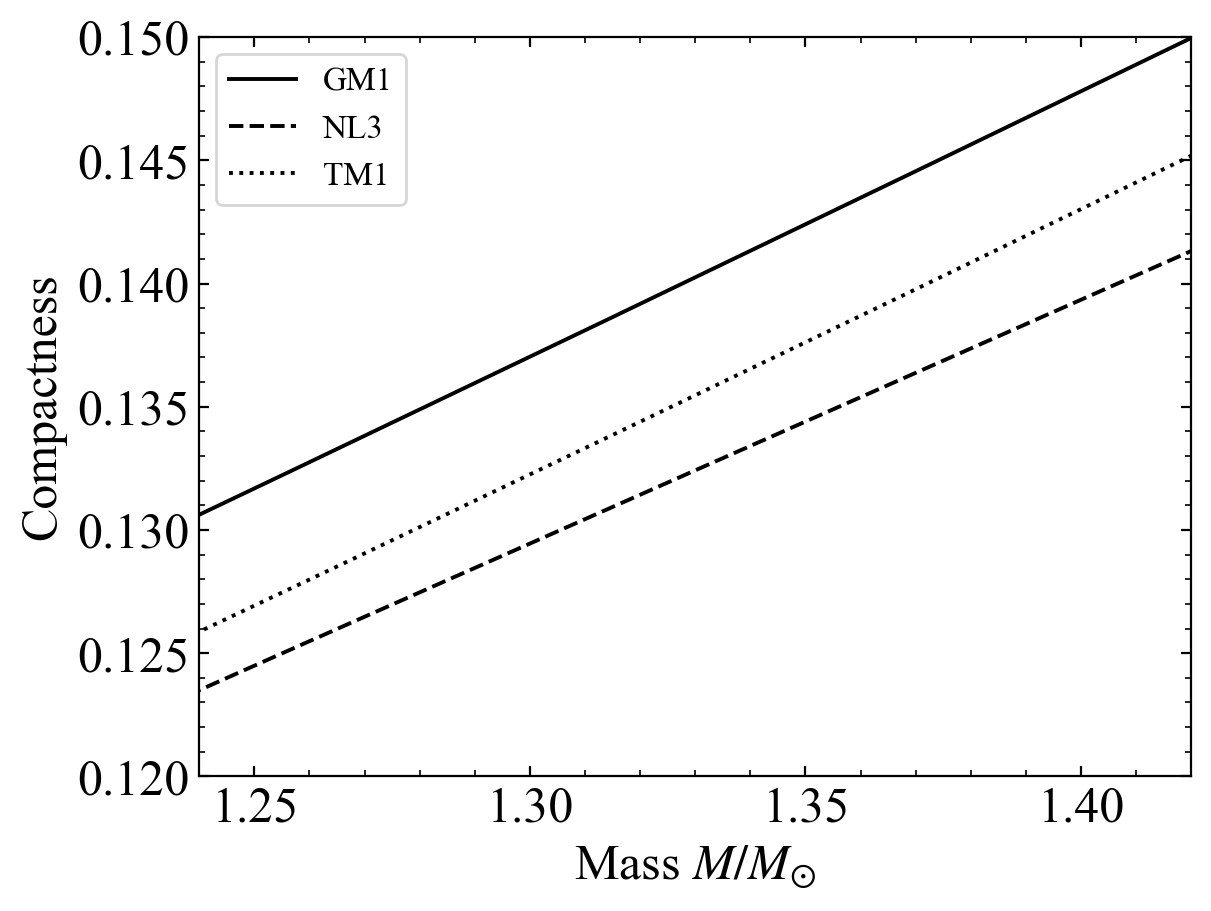

In [14]:
plt.figure()
for i in np.arange(1,len(filenames),2):
    plt.plot(M_data[filenames[i]],Compact[filenames[i][11:-4]], color='k', 
             linestyle=line_style[int(i/2)], label=filenames[i][11:-5])
plt.legend(loc='upper left', fontsize=12)
plt.xlabel(r'Mass $M/M_{\odot}$')
plt.xlim(1.24, 1.42)
plt.ylim(0.12, 0.15)
plt.ylabel(r'Compactness')
plt.savefig('compactness.pdf', bbox_inches='tight')

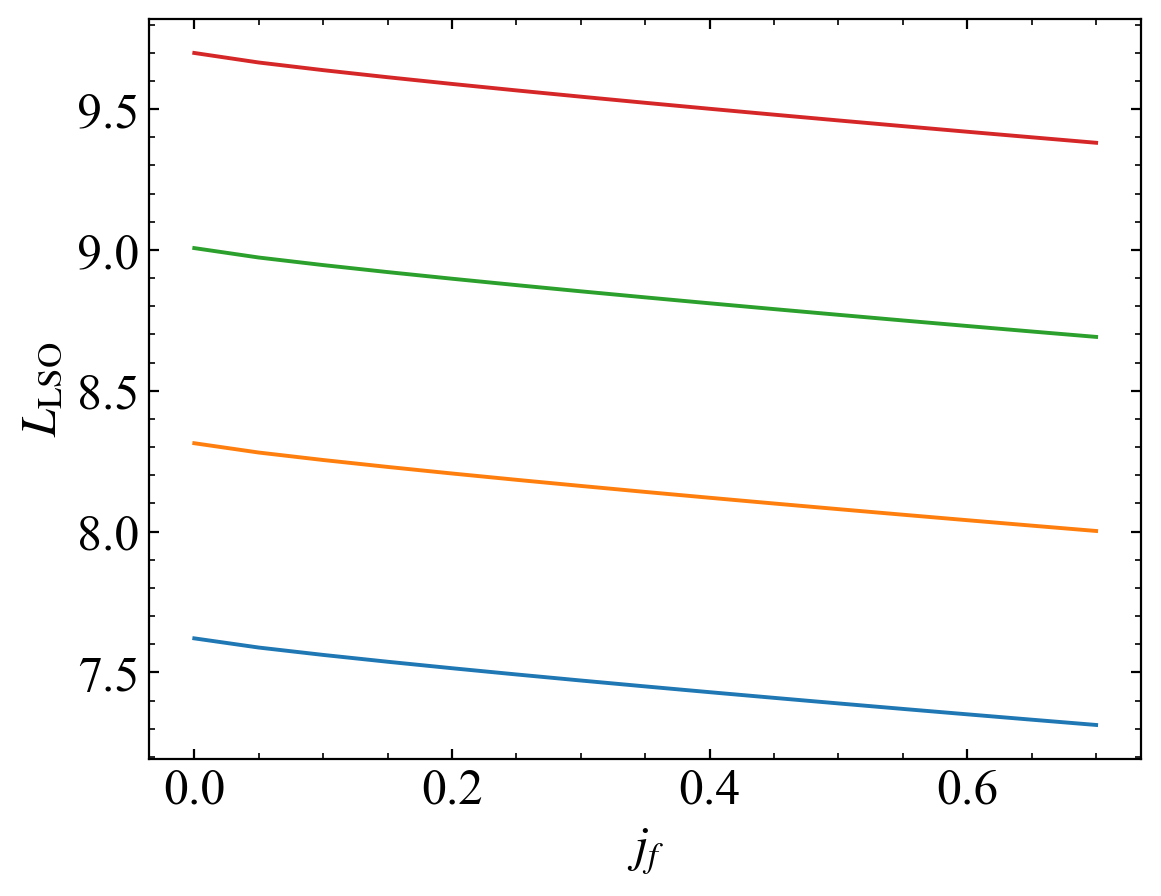

In [15]:
jnNS_free = np.arange(0.0,0.75,0.05)
mass_newNS = np.array([2.2,2.4,2.6,2.8])
for i in mass_newNS:
    L_LSO = L_LSOfunc(i*np.ones(len(jnNS_free)),jnNS_free)
    plt.plot(jnNS_free, L_LSO)
plt.xlabel(r'$j_f$')
plt.ylabel(r'$L_{\rm{LSO}}$')
plt.show()

## Tidal disruption and merger point
Total mass $M \equiv m_1+m_2$ and reduced mass $\mu = \frac{m_1m_2}{M}$.

Mass ratio definition
$$q\equiv\frac{m_1}{m_2}$$
$$m_1 = \frac{Mq}{(1+q)}$$
$$m_2 = \frac{M}{(1+q)}$$

Symmetric mass ratio
$$\nu \equiv \frac{m_1m_2}{M^2}=\frac{q}{(1+q)^2}$$

In [16]:
print (filenames)

['MassRadius_GM1G.dat' 'MassRadius_GM1L.dat' 'MassRadius_NL3G.dat'
 'MassRadius_NL3L.dat' 'MassRadius_TM1G.dat' 'MassRadius_TM1L.dat'
 'NSNS_Opt.txt']


In [17]:
q = 0.91
M0 = (1+q)/q*M_data['MassRadius_GM1L.dat'][0]
M1 = (1+q)*M_data['MassRadius_GM1L.dat'][-1]

m0 = np.linspace(M0, M1, 40)
m1 = m0*q/(1+q)
m2 = m0/(1+q)

print (m1[0], m2[-1])
print (M_data['MassRadius_GM1L.dat'][0], M_data['MassRadius_GM1L.dat'][-1])

0.43745229980000006 2.38647724
0.4374522998 2.38647724


In [18]:
R1 = m1/compactness_interGM1L(m1)/m0
R2 = m2/compactness_interGM1L(m2)/m0

r_td = 2.4*(1/q)**(1/3)*R1 
r_td_rel = 2.4*(1/q+1)**(1/3)*R1

r_cont = R1+R2

print (R1, R2)

[ 10.718  9.631  8.756  8.034  7.426  6.908  6.460  6.067  5.722  5.414
  5.139  4.890  4.665  4.460  4.272  4.099  3.939  3.792  3.654  3.525
  3.405  3.293  3.187  3.087  2.992  2.903  2.818  2.737  2.660  2.586
  2.515  2.447  2.382  2.319  2.258  2.199  2.141  2.084  2.029  1.973] [ 10.613  9.560  8.707  7.999  7.402  6.890  6.447  6.059  5.716  5.410
  5.136  4.888  4.663  4.458  4.269  4.096  3.936  3.787  3.648  3.519
  3.397  3.283  3.176  3.074  2.978  2.886  2.799  2.716  2.636  2.559
  2.485  2.414  2.344  2.276  2.209  2.142  2.074  2.004  1.926  1.800]


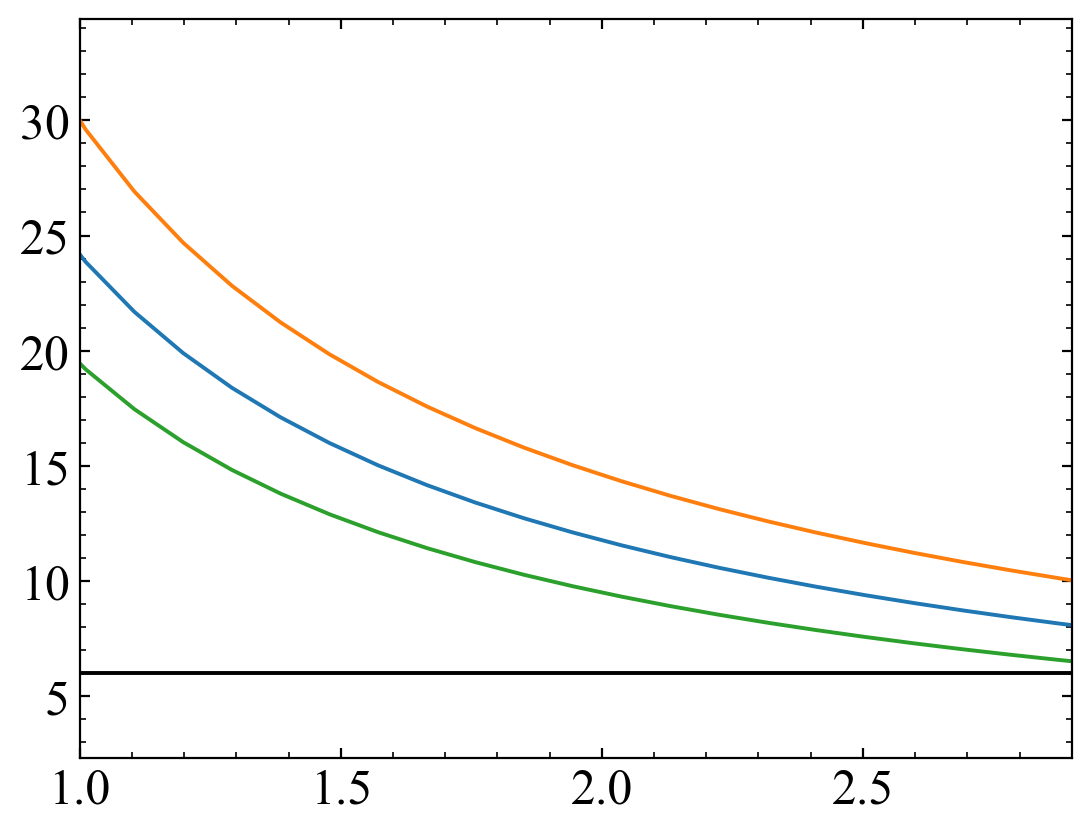

In [19]:
plt.figure()
plt.plot(m0, r_td)
plt.plot(m0, r_td_rel)
plt.plot(m0, r_cont)
plt.axhline(6, color='k')
plt.xlim(1, 2.9)
plt.show()

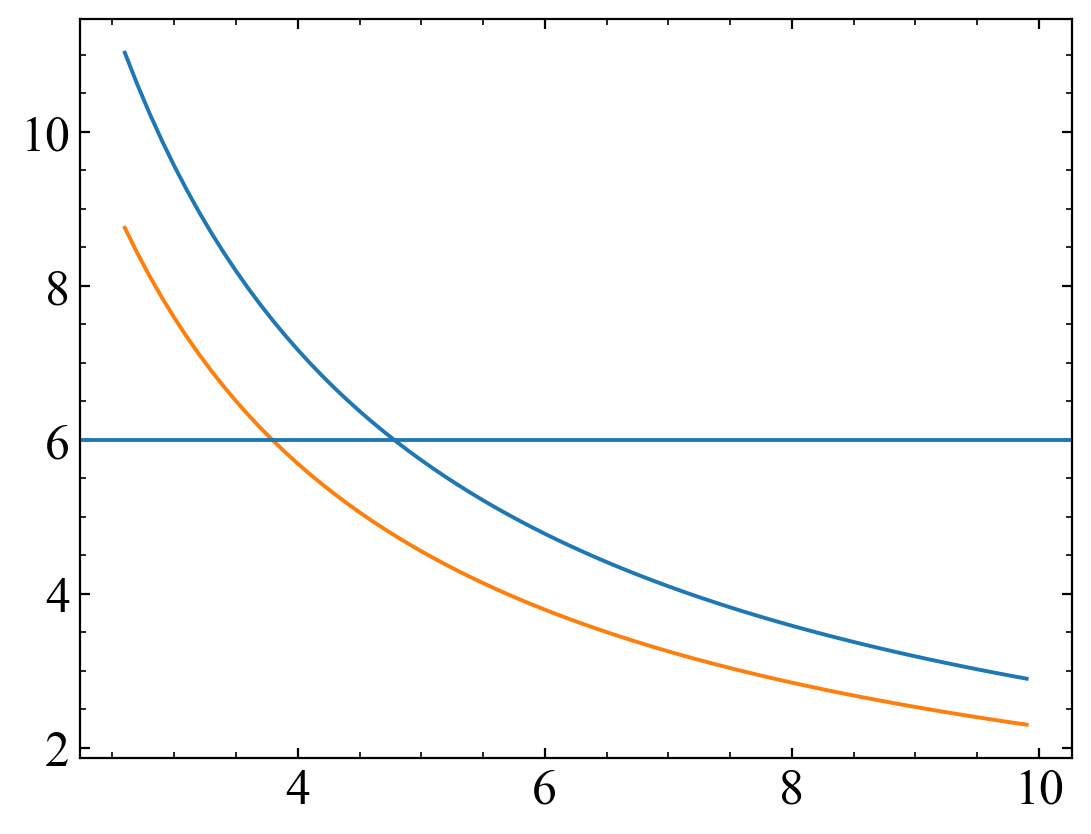

In [20]:
mtot = np.arange(2.6, 10, 0.1)
r_td_1 = 2.4*0.5**(-1/3)*1.33/compactness_interGM1L(1.33)/mtot
r_td_2 = 2.4*1**(-1/3)*1.33/compactness_interGM1L(1.33)/mtot
plt.figure()
plt.plot(mtot, r_td_1)
plt.plot(mtot, r_td_2)

plt.axhline(6)

## Remnant mass in the keplerian sequence

### Critical mass

In [21]:
STmass = ['-', '--', ':', '-.']
LBmass = ['NL3', 'GM1', 'TM1']
COLOR = ['C0','C1','C2']

In [22]:
M_crit_formula = []
pp = [1.68, 1.69, 1.61] # NL3 GM1 TM1
kk = [0.006, 0.011, 0.017]
M0crit = np.array([2.81, 2.39, 2.20])
for i, j in enumerate(pp):
    M_crit_formula.append(m_crit_kep(M0crit[i], kk[i], j))

In [23]:
M_crit = np.array([3.38, 2.84, 2.62])
print (M_crit_formula)
print (M_crit)

[3.345638437372506, 2.9422760916644, 2.7421969786463274]
[ 3.380  2.840  2.620]


### Minimum mass for equatorial radius smaller than the isco

In [24]:
c1 = np.array([0.225,0.242,0.238])
jmax = np.array([6.31, 4.98, 4.47])
M0_min = np.array([1.68, 1.57, 1.61])
c2 = 0.94
M_min = M0_min + c1*jmax**c2
print (M_min)

[ 2.951  2.664  2.582]


In [25]:
m_tot = 2*np.arange(1.23, 1.42, 0.005) # mass binary
m_totq = [2.66]
q = np.arange(0.8, 1, 0.001)
#m_ejecta = np.array([0, 0.01, 0.05]) # mass ejecta
m_other = np.array([0., 0.01, 0.15])
m_c = np.empty((len(m_other),len(m_tot))) # mass remnant NS core
m_cq = np.empty((len(m_other),len(q)))
for i in np.arange(0, len(m_other)):
    for j in np.arange(0, len(m_tot)):
        m_c[i,j] = massnNS_keplerian(m_tot[j]/2, m_other[i])
for i in np.arange(0, len(m_other)):
    for j in np.arange(0, len(q)):
        m_cq[i,j] = massnNS_keplerian_from_q(m_totq[0], q[j], m_other[i])

The total mass interval includes the lowest and highest value of observed BNS. The $q=m_2/m_1$ is chosen from the lower value of the observed BNSs, Ozel & Friere (2016)

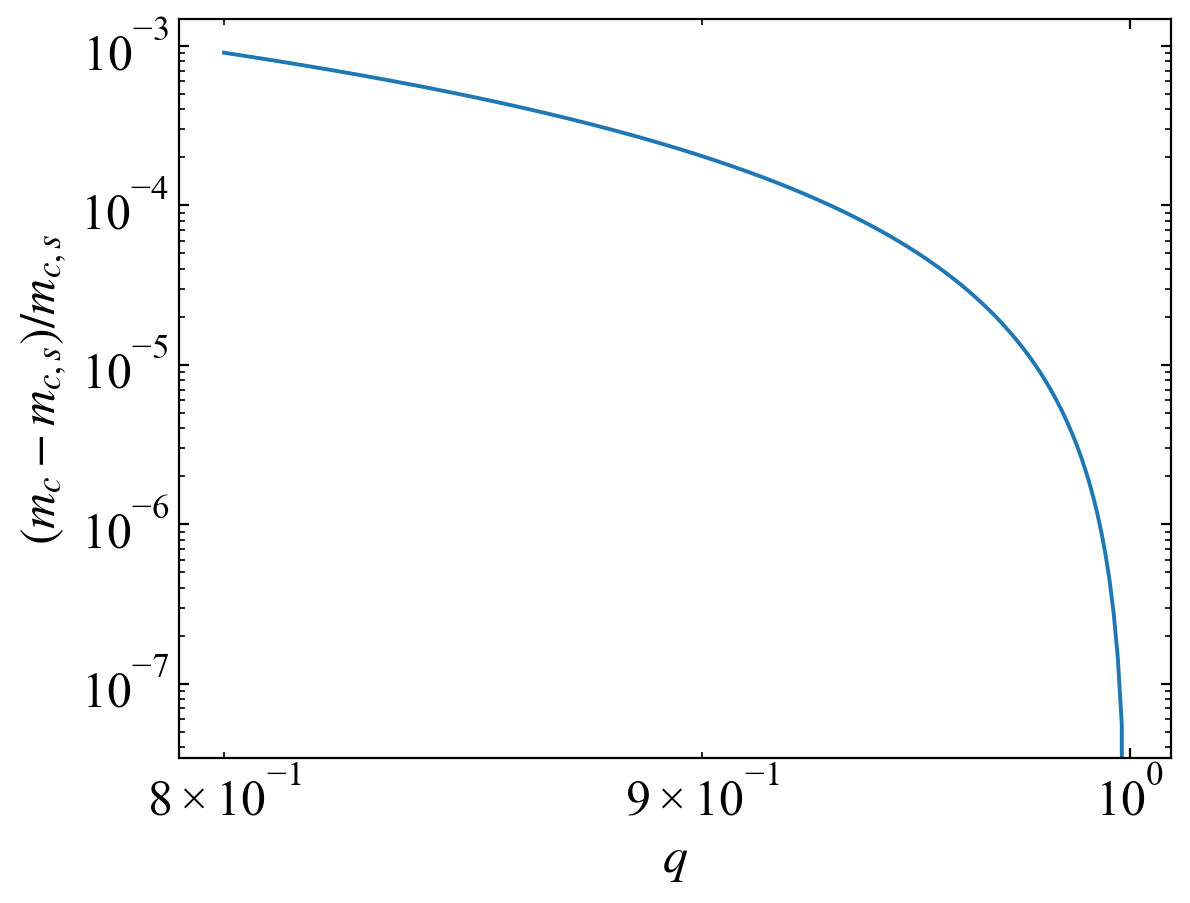

In [26]:
plt.figure()
for i in np.arange(0, 1):
    plt.loglog(q, (m_cq[i,:]-m_cq[i,-1])/m_cq[i,-1])
plt.xlabel(r'$q$')
plt.ylabel(r'$(m_c - m_{c,s})/m_{c,s}$')
plt.savefig('mc_q.pdf', bbox_inches='tight')

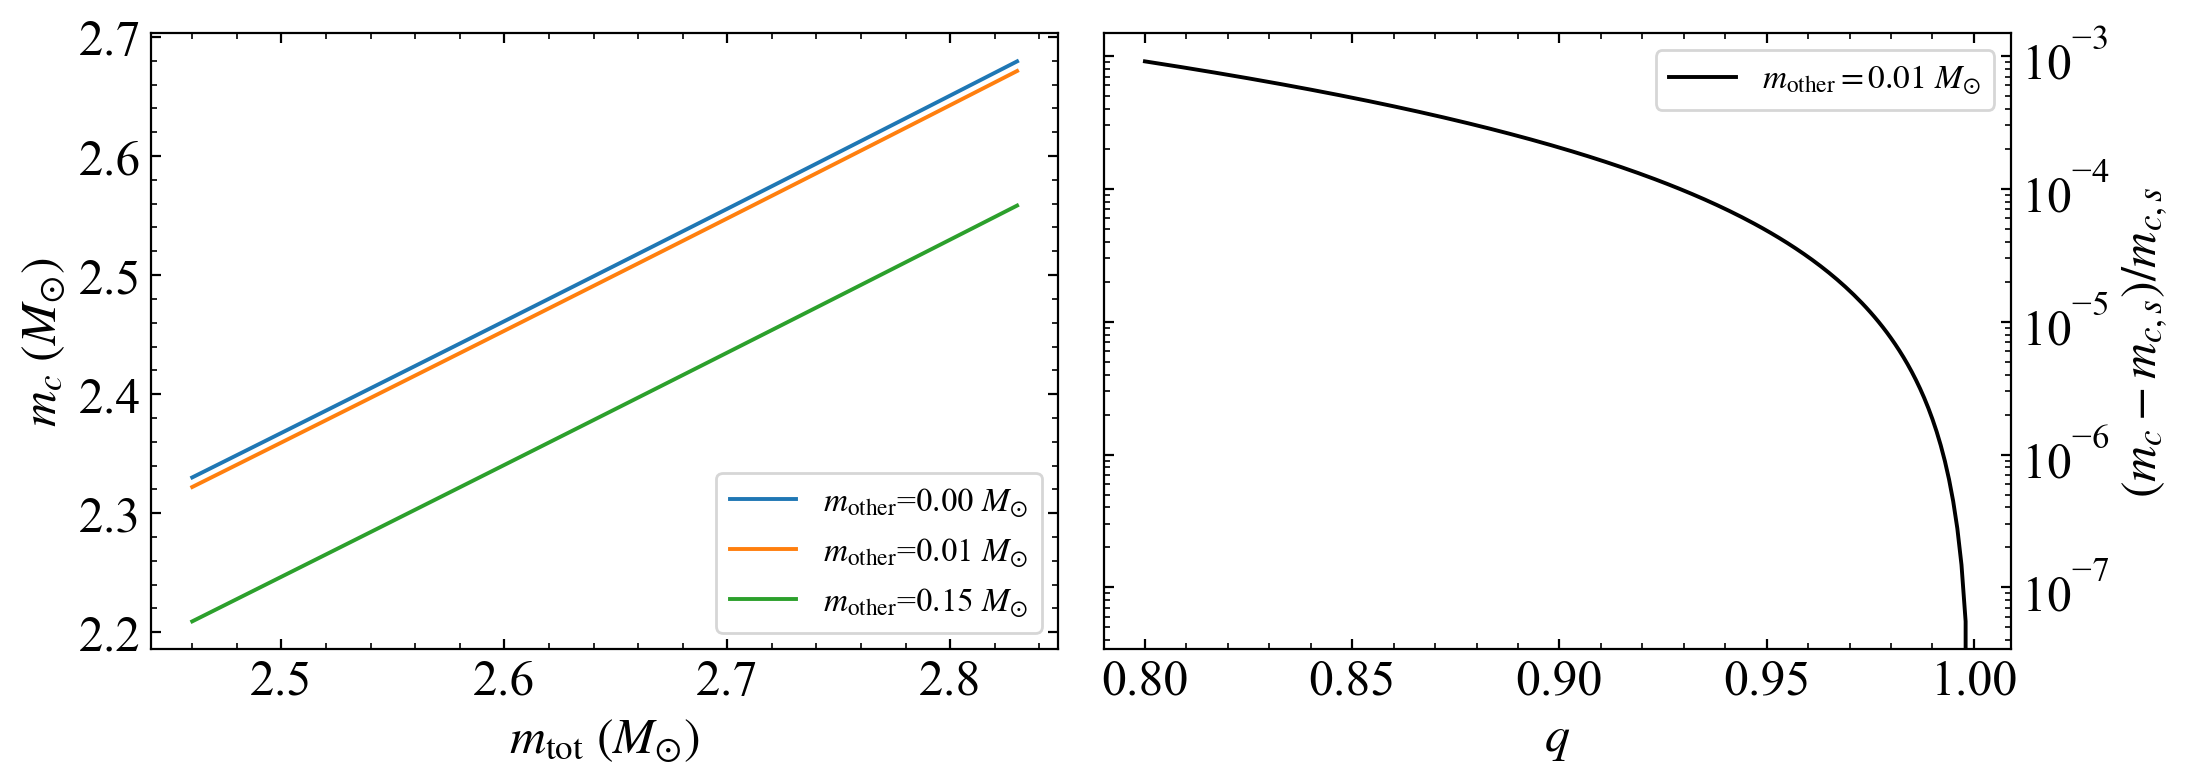

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for i in np.arange(0, len(m_other)):
    plt.plot(m_tot, m_c[i,:], label=r'$m_{{\rm other}}$={0:.2f} $M_{{\odot}}$'.format(m_other[i]))
#for i in np.arange(1, 2):
    #plt.plot([m_tot[0], m_tot[-1]], [M_crit[i], M_crit[i]], STmass[i], label=LBmass[i], alpha=0.5)
    #plt.plot([m_tot[0], m_tot[-1]], [M_min[i], M_min[i]], STmass[i], alpha=0.5)
#for i in np.arange(0, len(q)):
#    plt.plot(m_tot, m_cq[i,:])  
#plt.plot(m_tot, 0.946*m_tot, 'k')
plt.xlabel(r'$m_{\rm tot}\ (M_{\odot})$')
plt.ylabel(r'$m_c \ (M_{\odot})$')
plt.legend(fontsize=12, ncol=1, loc='lower right')
plt.subplot(1,2,2)
for i in np.arange(1, len(m_other)-1):
    plt.semilogy(q, (m_cq[i,:]-m_cq[i,-1])/m_cq[i,-1],'k', label=r'$m_{{\rm other}} = {0:.2f}\ M_{{\odot}}$'.format(m_other[i]))
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax = plt.gca()
ax.yaxis.set_label_position('right')
plt.xlabel(r'$q$')
plt.ylabel(r'$(m_c - m_{c,s})/m_{c,s}$')
plt.subplots_adjust(wspace=0.05)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('mass_core_kep.pdf', bbox_inches='tight')

In [28]:
m_i_min = []
m_i_max = []

for j in np.arange(0, len(m_other)-1):
    m_core_interp = interp1d(m_tot/2, m_c[j,:])
    def func1(m, m_min):
        return m_core_interp(m) - m_min
    m_min = []
    m_max = []
    for i in np.arange(1, len(M_min)):
        m_min.append(fsolve(func1, 1.24, (M_min[i]))[0])
        #m_max.append(fsolve(func1, 1.26, (M_crit[i]))[0])
    m_i_min.append(m_min)
    #m_i_max.append(m_max)
m_i_min = np.array(m_i_min)
#m_i_max = np.array(m_i_max)

In [51]:
print (LBmass[1:])
print (m_i_min[1])
#print m_i_max[1]

['GM1', 'TM1']
[ 1.411  1.368]


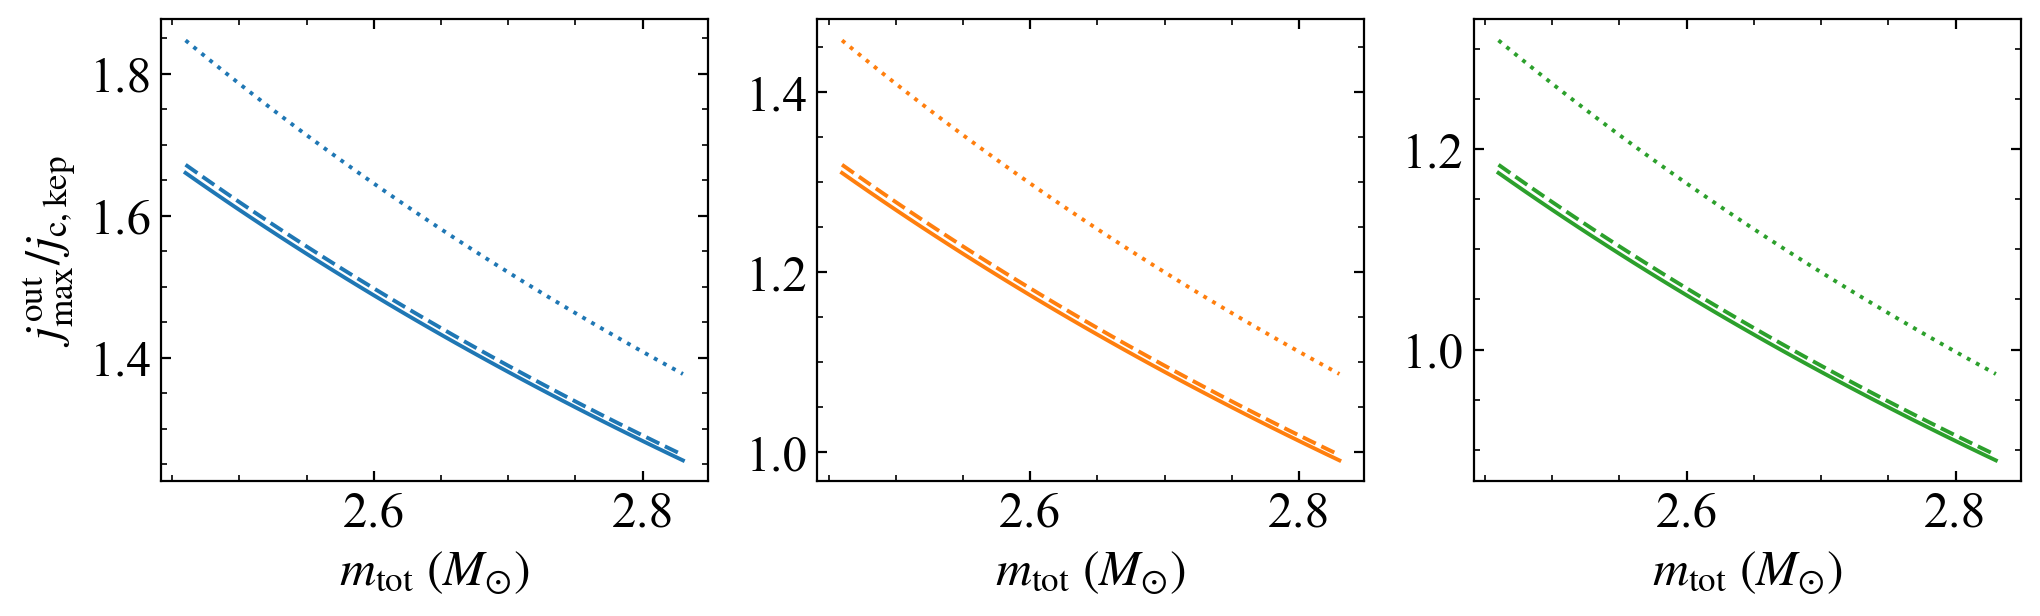

In [52]:
plt.figure(figsize=(12,3))
for i in np.arange(0, len(jmax)):
    plt.subplot(1,3,i+1)
    if i == 0:
        plt.ylabel(r'$j_{\rm max}^{\rm out}/j_{\rm c, kep}$')
    for j in np.arange(0,len(m_other)):
        plt.plot(m_tot, jmax[i]/(0.7*m_c[j,:]**2), color=COLOR[i], linestyle=STmass[j])
    plt.xlabel(r'$m_{\rm tot}\ (M_{\odot})$')
plt.savefig('isco_out_mtot.pdf', bbox_inches='tight')

In [53]:
print (jmax/M_min**2)

[ 0.724  0.701  0.670]


### TM1 special case

In [33]:
m_disk = np.arange(0.0,0.188+0.0001,0.0001)
m_coreTM1 = np.empty((len(m_disk),len(m_tot)))
for i in np.arange(0, len(m_disk)):
    for j in np.arange(0, len(m_tot)):
        m_coreTM1[i,j] = massnNS_keplerian(m_tot[j]/2, m_other=m_disk[i])

In [34]:
j_ratio = jmax[-1]/(0.7*m_coreTM1**2)
m_tot_disc = []

In [35]:
for i in np.arange(0, len(m_disk)):
    my_func = interp1d(m_tot, j_ratio[i,:]-1) 
    m_tot_disc.append(fsolve(my_func, m_tot[0])[0])


/Users/jose/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [36]:
m_tot_disc = np.array(m_tot_disc)

In [37]:
mNS_remnant_test = []
for i in np.arange(0, len(m_tot_disc)):
    mNS_remnant_test.append(massnNS_keplerian(m_tot_disc[i]/2, m_other=m_disk[i]))
mNS_remnant_test = np.array(mNS_remnant_test)

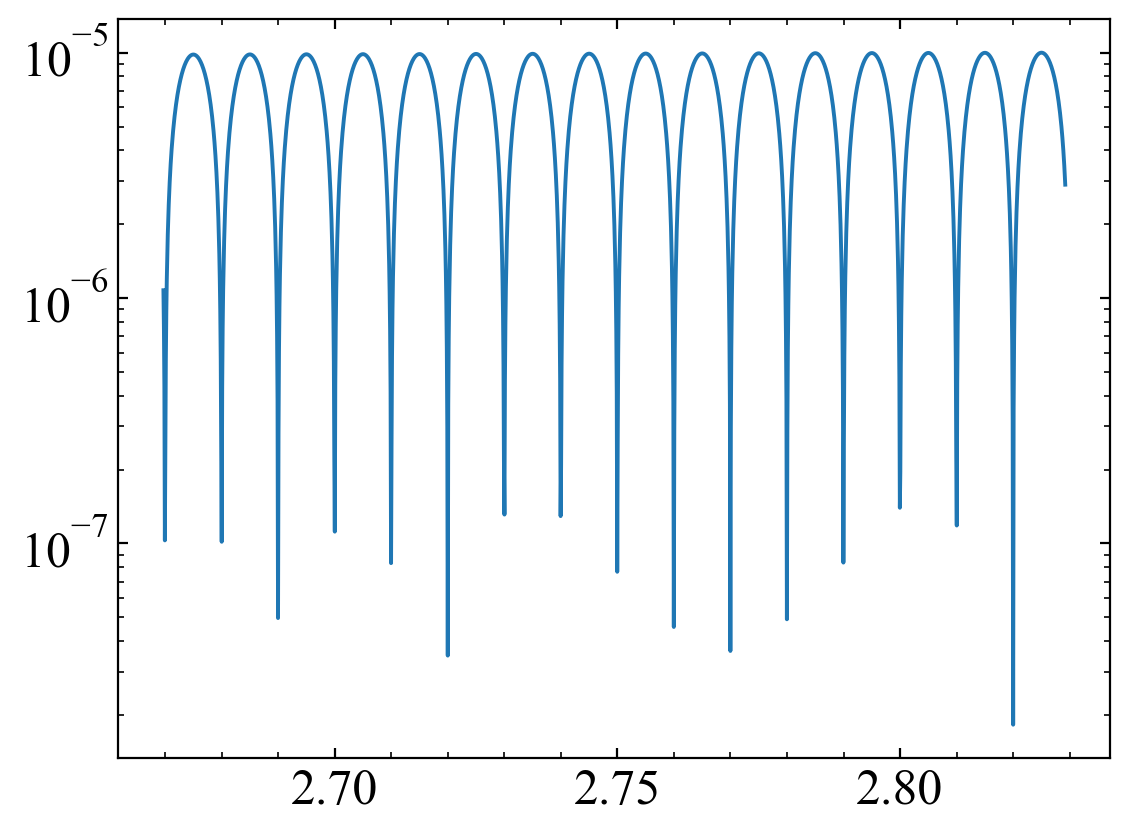

In [38]:
plt.figure()
plt.semilogy(m_tot_disc, np.abs(1-0.7*mNS_remnant_test**2/jmax[-1]))
plt.show()

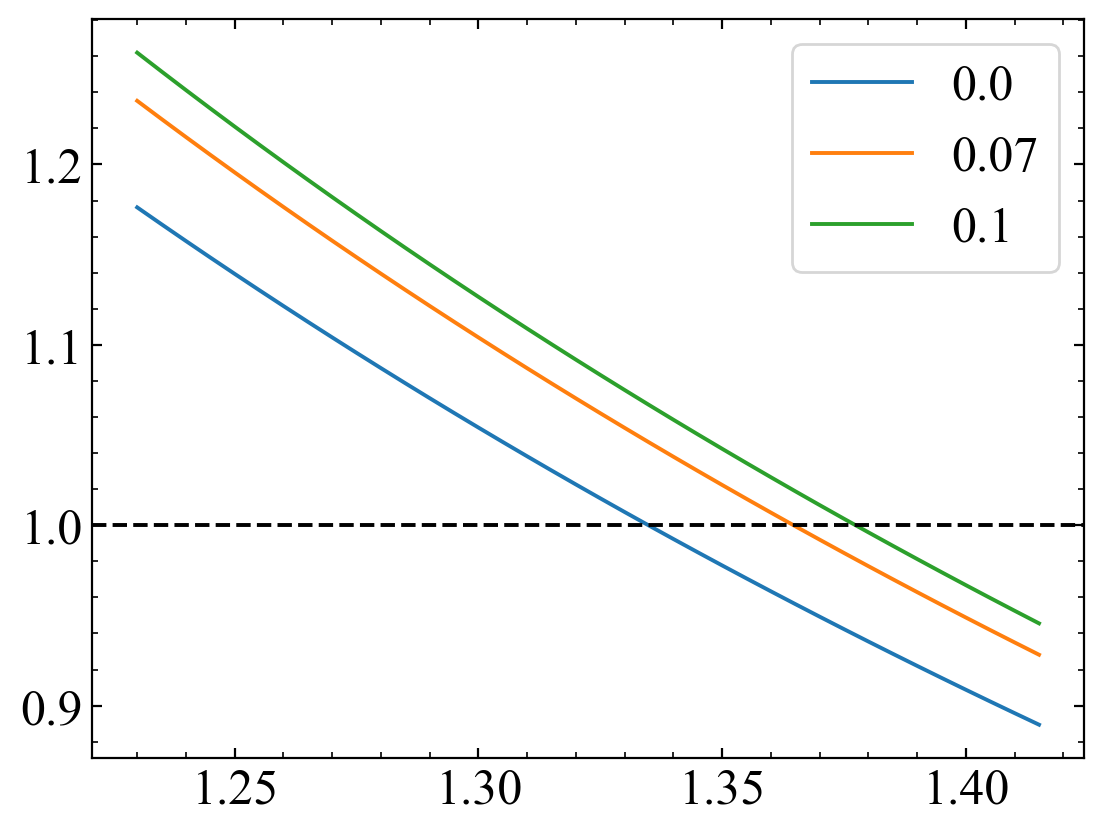

In [39]:
plt.figure()
plt.plot(m_tot/2,jmax[-1]/(0.7*m_coreTM1[0,:]**2), label=m_disk[0])
plt.plot(m_tot/2,jmax[-1]/(0.7*m_coreTM1[700,:]**2), label=m_disk[700])
plt.plot(m_tot/2,jmax[-1]/(0.7*m_coreTM1[1000,:]**2), label=m_disk[1000])
plt.legend()
plt.axhline(1,color='k', linestyle='--')
plt.show()

In [40]:
print (massnNS_keplerian(1.335, m_other=0))
print (massnNS_keplerian(1.365, m_other=0.07))
print (massnNS_keplerian(1.378, m_other=0.1))

2.5272635723839323
2.5276904736422434
2.5282024935320138


## No disk for mass-shedding limit

In [41]:
L_LSO_kep = L_LSOfunc(m_c, 0.7*m_c**2)
compNS = np.array([ compactness_interNL3L(m_tot/2) , compactness_interGM1L(m_tot/2) , compactness_interTM1L(m_tot/2) ])
l_max = m_tot*compNS**-0.5


q = 0.6
m1 = m_tot / (1+q)
m2 = m_tot - m1
C1 = compactness_interTM1L(m1)
C2 = compactness_interTM1L(m2)
l_max_q = l_max_from_mtotqC1C2(m_tot, q, C1, C2)


In [42]:
m_c_disc = []
for i in np.arange(0, len(m_tot_disc)):
    m_c_disc.append(massnNS_keplerian(m_tot_disc[i]/2, m_disk[i]))
m_c_disc = np.array(m_c_disc)
L_LSO_kep_disc = L_LSOfunc(m_c_disc, 0.7*m_c_disc**2)
l_max_disc = m_tot_disc*compactness_interTM1L(m_tot_disc/2)**-0.5

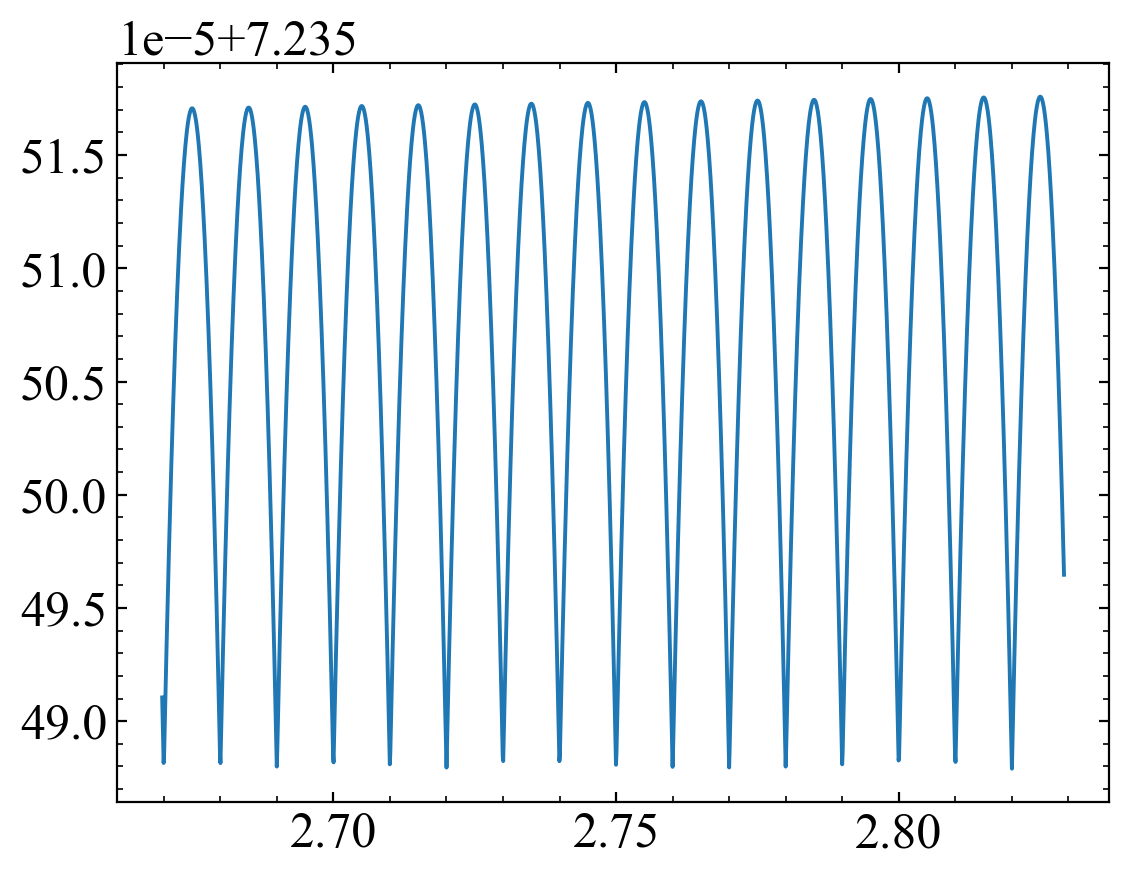

In [43]:
plt.figure()
plt.plot(m_tot_disc,L_LSO_kep_disc)
plt.show()

In [44]:
my_switch = 0
if my_switch:
    ST = ['-','--',':']
    EOS = ['NL3', 'GM1', 'TM1']
    COLOR = ['C0', 'C1']
    plt.figure(figsize=(12,4))
    for j in np.arange(0, len(compNS)-1):
        plt.subplot(1,2,j+1)
        for i in np.arange(0, len(m_ejecta)):
            IDX = np.where((m_i_min[i,j]<m_bi)&(m_bi<m_i_max[i,j]))[0]
            plt.plot(m_bi[IDX], l_max[j+1,IDX]/L_LSO_kep[i,IDX], ST[i], color=COLOR[j], label=r'{0:.2f} $M_{{\odot}}$'.format(m_ejecta[i]))
        plt.xlabel(r'$m\ (M_{{\odot}})$')
        if j == 1:
            plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
        else:
            plt.ylabel(r'$l^{{\rm max}}_{\rm mrg}/l_{c,{\rm ISCO}}$')
            plt.legend(loc='upper right', fontsize=12)
    plt.subplots_adjust(wspace=0.05)
    plt.savefig('l_isco-merger.pdf', bbox_inches='tight')

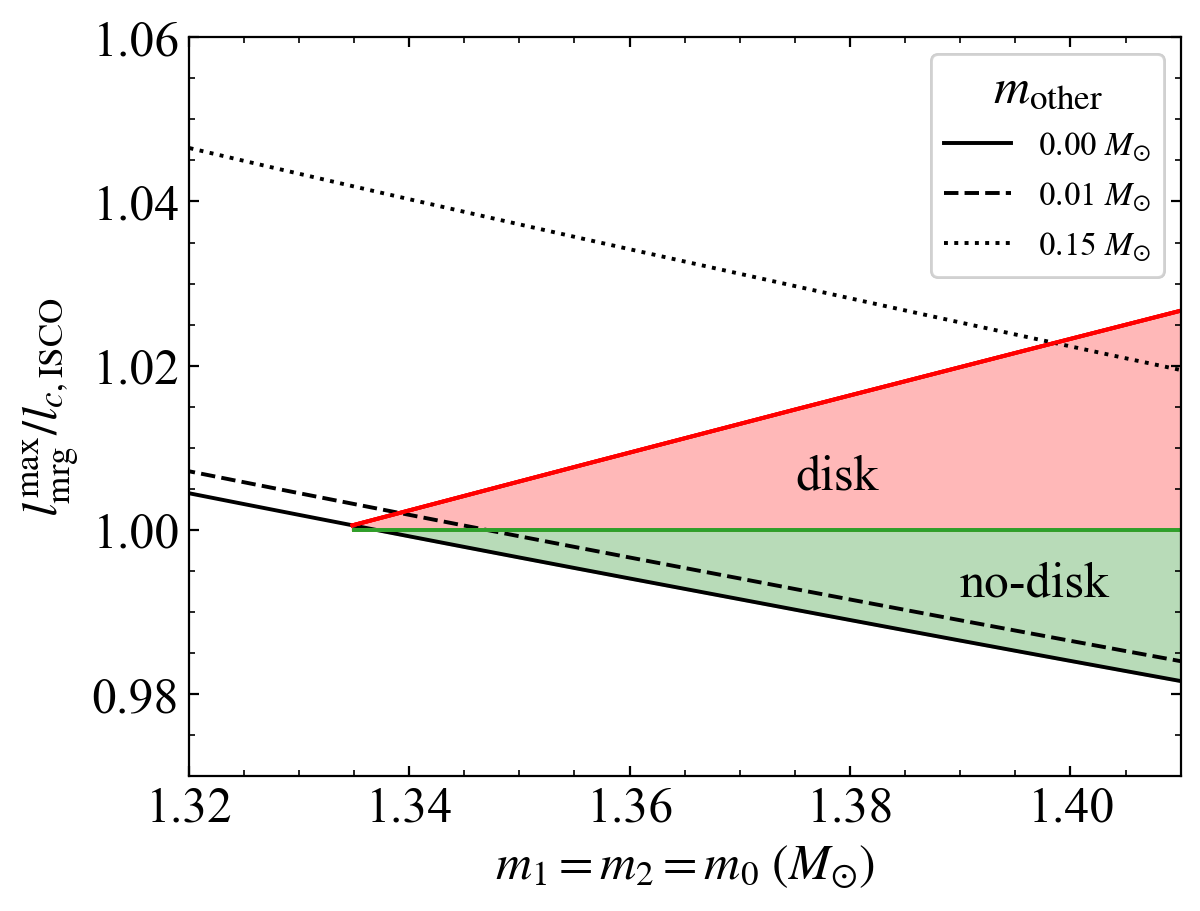

In [45]:
ST = ['-','--',':']
EOS = ['NL3', 'GM1', 'TM1']
handles1 = []
handles2 = []
IDX_dis = np.where((m_tot>m_tot_disc[0]))[0]#&(m_tot<m_tot_disc[-1]))[0]
plt.figure()
for i in np.arange(0, len(m_other)):
    l1, = plt.plot(m_tot/2, l_max[-1,:]/L_LSO_kep[i,:], 
                            ST[i], color='k', 
                            label=r'{0:.2f} $M_{{\odot}}$'.format(m_other[i]))
    #plt.plot(m_tot, l_max_q/L_LSO_kep[i,:], 
    #                        ST[i], color='C1', 
    #                        label=r'{0:.2f} $M_{{\odot}}$'.format(m_other[i]))
    plt.plot(m_tot_disc/2, l_max_disc/L_LSO_kep_disc, 'r')
    plt.plot(m_tot[IDX_dis]/2, np.ones(len(m_tot[IDX_dis])))
    plt.fill_between(m_tot_disc/2, l_max_disc/L_LSO_kep_disc, np.ones(len(m_tot_disc)),
                     color='red', alpha=0.1)
    plt.fill_between(m_tot[IDX_dis]/2, l_max[-1,IDX_dis]/L_LSO_kep[0,IDX_dis], np.ones(len(m_tot[IDX_dis])),
                     color='green', alpha=0.1)
    handles1.append(l1) 
first_legend = plt.legend(handles=handles1, loc=0, fontsize=12, title=r'$m_{\rm other}$')
ax = plt.gca().add_artist(first_legend)
#plt.text(2.5, 1.03,'arepahuevo')
plt.text(2.75/2, 1.005,'disk')
plt.text(2.78/2, 0.992,'no-disk')
#for i in np.arange(1, len(compNS)):
#    l2, = plt.plot(m_bi, l_max[i,:], label=EOS[i])
#    handles2.append(l2)
#plt.legend(handles=handles2, loc=4, fontsize=12, title=r'$l^{{\rm max}}_{\rm mrg}$')
#plt.plot(m_tot, l_max[-1,:])
plt.xlim(1.32, 1.41)
plt.ylim(0.97, 1.06)
plt.xlabel(r'$m_1 = m_2 = m_0\ (M_{{\odot}})$')
plt.ylabel(r'$ l^{\rm max}_{\rm mrg}/l_{c,\rm ISCO}$') # \ (G M_{{\odot}}/c)$')
plt.savefig('l_isco-merger.pdf', bbox_inches='tight')

Changing the $q$ doesn't improve the formation since the more massive star is compressed more than the expansion of the less massive. When more mass is given to the disk,  the angular momentum of the ISCO is reduced, therefore is easier to form a disk. It can be seen that the dotted line is always greater than 1, so the particle has more angular momentum with respect the ISCO that was reduced. However the more mass is given to disk the less is left in the star and its radius grows, eventually absorbing the ISCO. If I try to form a more massive disk, it will be absorbed by the star.

In [45]:
m_tot_disc[0]/2

1.3348597600487657

## Constraints in Mass vs Radius

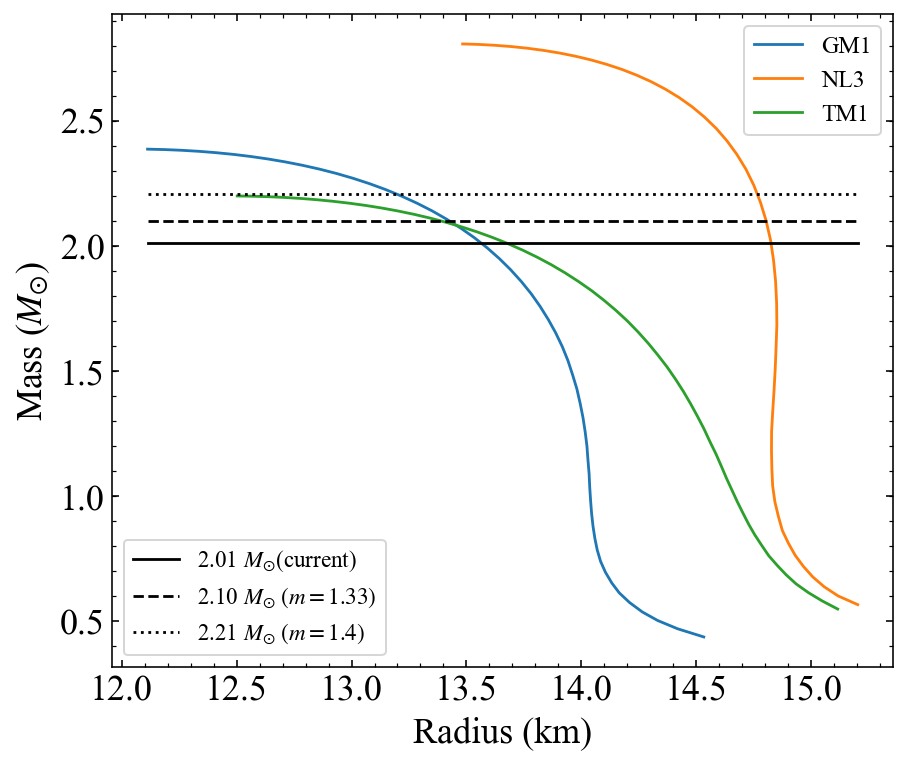

In [47]:
plt.figure(figsize=(7,6))
Rmin = 20
Rmax = 0
m_crit1 = massnNS_keplerian(1.33, 0)/1.2
m_crit2 = massnNS_keplerian(1.4, 0)/1.2
m = np.arange(1.,1.45,0.05)
Rcrit = 1.33*m*(2*np.sqrt(3)-0.45*m**0.85)**2
handles1 = []
for i in np.arange(1,len(filenames),2):
    if np.min(R_data[filenames[i]]) < Rmin: 
        Rmin = np.min(R_data[filenames[i]])
    if np.max(R_data[filenames[i]]) > Rmax:
        Rmax = np.max(R_data[filenames[i]])
    l1, = plt.plot(R_data[filenames[i]], M_data[filenames[i]], label=filenames[i][11:-5]) 
             #color='k', linestyle=line_style[int((i)/2)])
    handles1.append(l1)
first_legend = plt.legend(loc='upper right', handles=handles1, fontsize=12)
ax = plt.gca().add_artist(first_legend)
l2, = plt.plot([Rmin, Rmax], [2.01, 2.01], 'k', label=r'2.01 $M_{{\odot}}$(current)')
l3, = plt.plot([Rmin, Rmax], [m_crit1, m_crit1], 'k--', label=r'{0:.2f} $M_{{\odot}}\ (m=1.33)$'.format(m_crit1))
l4, = plt.plot([Rmin, Rmax], [m_crit2, m_crit2], 'k:', label=r'{0:.2f} $M_{{\odot}}\ (m=1.4)$'.format(m_crit2))
#idx = np.where(Rcrit<Rmax)
#l5, = plt.plot(Rcrit, m, label=r'$R_{{\rm discr}}$')
handles2 = [l2,l3, l4]
plt.legend(loc='lower left',  handles = handles2, fontsize=11.5, ncol=1)
plt.xlabel('Radius (km)')
plt.ylabel(r'Mass ($M_{\odot}$)')
#plt.xlim(11.5,15.5)
plt.savefig('M-R_local.pdf', bbox_inches='tight')

In [55]:
0.37*(0.7*1.9)**0.85

0.4714934011506567

In [181]:
2.8*0.01

0.027999999999999997

In [70]:
tSol*clight*(1.9/2)**2

1332.708071803217

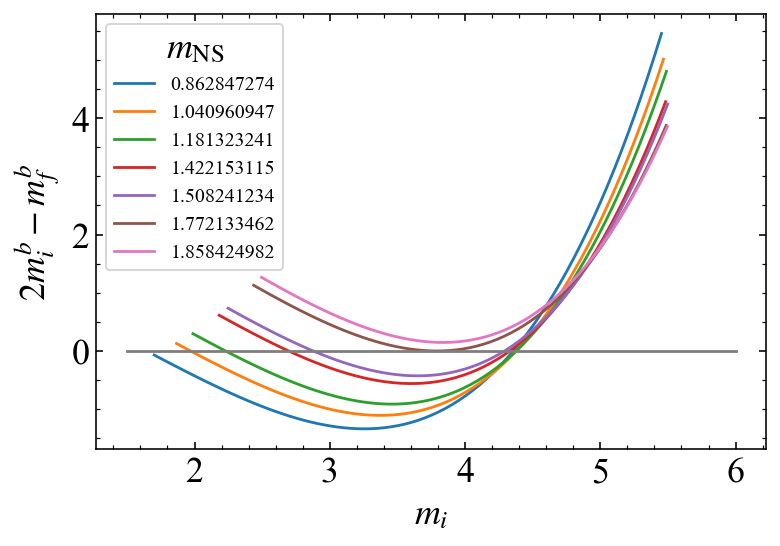

In [16]:
k = np.array([7, 10, 12, 15, 16, 19, 20])
plt.figure()
for i in k:
    mass_init = mass_i(M_data[filenames[3]][i], Compact['NL3L'][i])
    #print mass_init, k
    mass = np.arange(mass_init, 5.5, 0.05)
    #plt.plot(mass, jfunc(M_data[filenames[3]][15], mass, Compact['NL3L'][15]), 'k')
    #plt.plot(mass, massfunc(M_data[filenames[3]][20], mass, Compact['NL3L'][20]), 'k')
    plt.plot(mass, mass_eq(M_data[filenames[3]][i], mass, Compact['NL3L'][i]), label=M_data[filenames[3]][i])
plt.plot([1.5, 6.], [0, 0])
plt.xlabel(r'$m_i$')
plt.ylabel(r'$2m_i^b - m_f^b$')
plt.legend(loc='upper left', fontsize=10, title=r'$m_{\rm{NS}}$')
plt.show()

In [12]:
j_var = np.arange(0, 10, 0.05)
mass_final = []
ratio = []

m_init = M_data[filenames[3]]
comp_init = Compact['NL3L']

for i in np.arange(0,len(m_init)):
    m_aux = []
    ratio_aux = []
    for j in np.arange(0, len(j_var)):
        m_aux.append(massnNS_j(m_init[i] , j_var[j]))
        ratio_aux.append(ratio_func(m_init[i], comp_init[i], j_var[j]))
    mass_final.append(m_aux)
    ratio.append(ratio_aux)
mass_final = np.array(mass_final)
ratio = np.array(ratio)

a_plot = np.arange(0, 0.85, 0.05)
ratio_a = []
for i in np.arange(0, len(a_plot)):
    ratio_a.append(ratio_func_a(1.39, a_plot[i])[0])

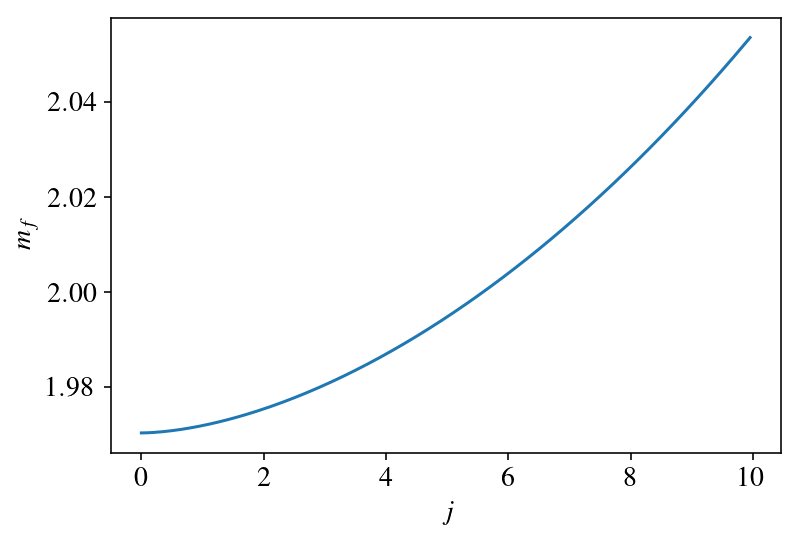

In [13]:
plt.figure()
plt.plot(j_var, mass_final[10])
plt.xlabel('$j$')
plt.ylabel(r'$m_f$')
plt.show()

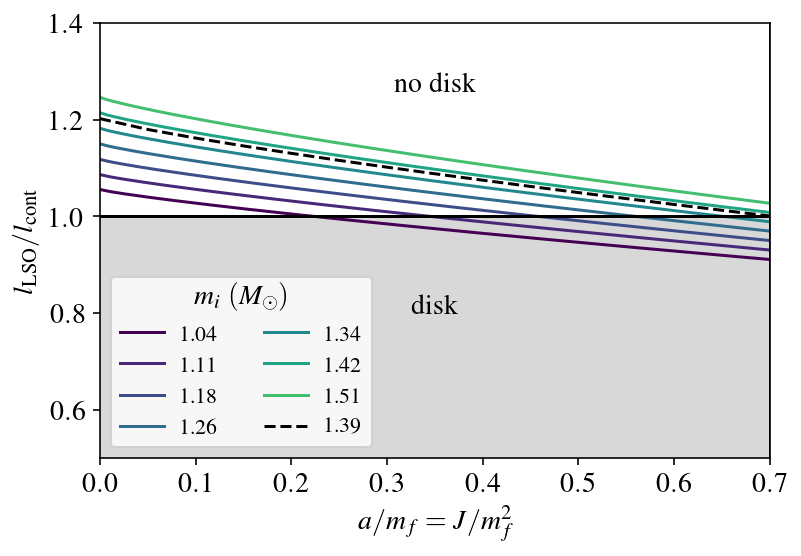

In [14]:
n_lines = 7
a_vec = np.array([0, 0.7])
rat_1 = np.array([1. ,1.])
################################################
plt.figure()
ax = plt.axes()
ax.set_prop_cycle(cycler('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.7, n_lines)]))
for i in np.arange(10,17):
    plt.plot(j_var/mass_final[i]**2, ratio[i], label = '{0:.2f}'.format(m_init[i]))
################################################
plt.plot(a_plot, ratio_a, 'k--', label='1.39')
################################################
plt.plot([0., 0.8], rat_1, 'k') # limit disk formation
plt.plot([0.7, 0.7], [0.5, 1.4], 'k') # mass shedding
############# Fill #############################
plt.fill_between(a_vec, rat_1, 0, color = 'gray', alpha = 0.3)
#plt.fill_between(a_vec, rat_1, 1.5, color = 'gray', alpha = 0.7)
############# text #############################
x_text, y1_text, y2_text = 0.35, 0.8, 1.26 
plt.text(x_text, y1_text, 'disk', ha='center')
plt.text(x_text, y2_text, 'no disk', ha='center')
################################################
plt.xlim(0,0.7)
plt.ylim(0.5,1.4)
plt.xlabel(r'$a/m_f=J/m_f^2$')
plt.ylabel(r'$l_{\rm{LSO}}/l_{\rm{cont}}$')
plt.legend(loc='lower left', fontsize = 11, title = r'$m_i\ (M_{\odot}) $', ncol=2)

plt.savefig('ratio.pdf', bbox_inches='tight')

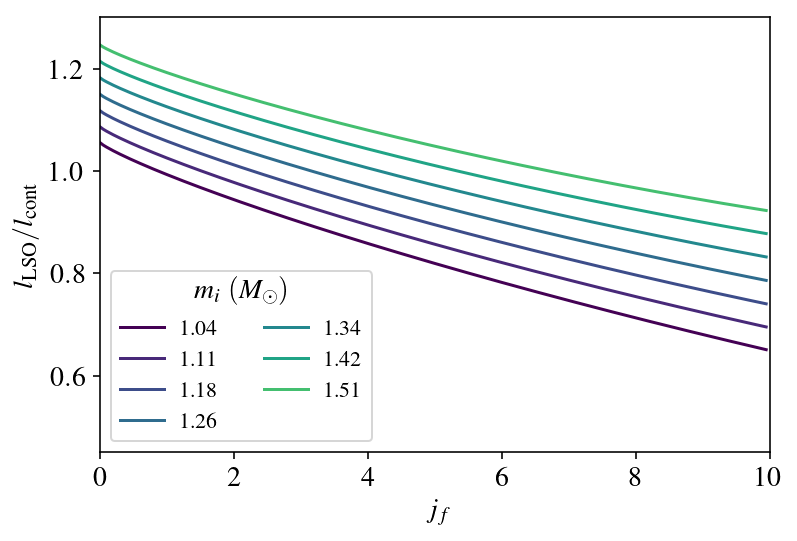

In [15]:
plt.figure()
ax = plt.axes()
ax.set_prop_cycle(cycler('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.7, n_lines)]))
for i in np.arange(10,17):
    plt.plot(j_var, ratio[i], label = '{0:.2f}'.format(m_init[i]))
plt.xlabel(r'$j_f$')
plt.ylabel(r'$l_{\rm{LSO}}/l_{\rm{cont}}$')
plt.legend(loc='lower left', fontsize = 11, title = r'$m_i\ (M_{\odot}) $', ncol=2)
plt.xlim(0, 10.)
plt.ylim(0.45,1.3)
plt.savefig('ratio-j.pdf', bbox_inches='tight')

In [16]:
def eq_mass_init_max(m_init):
    return ratio_func_a(m_init, 0.7)[0]-1
m_init_max = fsolve(eq_mass_init_max, 1.2)[0]
jNS_max = ratio_func_a(m_init_max, 0.7)[1]
mnNS_max = ratio_func_a(m_init_max, 0.7)[2]

print m_init_max, mnNS_max, jNS_max

1.38659417145 2.62519163642 4.82414178955


## Maximum mass conserving angular momentum for NL3 local

In [17]:
Compact['NL3L'][9:16]

array([ 0.09724082,  0.10364004,  0.1104347 ,  0.11765486,  0.12528175,
        0.13325728,  0.1415343 ])

In [18]:
mnuNS = []

for i in np.arange(9,16):
    mnuNS.append(massnNS(M_data[filenames[3]][i], Compact['NL3L'][i]))
mnuNS = np.array(mnuNS)

j_NL3 = jfunc(M_data[filenames[3]][9:16], mnuNS, Compact['NL3L'][9:16])
jm_NL3 = 1.4*M_data[filenames[3]][9:16]**2*Compact['NL3L'][9:16]**-0.5

##### interpolation #########
mfNS_inter = interp1d(j_NL3, mnuNS, kind='quadratic')

In [19]:
j_const = np.linspace(0, 12, 7, endpoint=True)
mass_final_j = []

m_init = M_data[filenames[3]]
m_init_0 = M_data[filenames[3]][9:16]

for i in np.arange(0,len(j_const)):
    m_aux = []
    for j in np.arange(0, len(m_init)):
        m_aux.append(massnNS_j(m_init[j] , j_const[i]))
    mass_final_j.append(m_aux)
    
mass_final_j = np.array(mass_final_j)
mass_final_MS = []

for i in np.arange(0, len(m_init_0)):
        mass_final_MS.append(m_final_func_a(m_init_0[i] , 0.7))

mass_final_MS = np.array(mass_final_MS)



In [13]:
mf = m_final_func_a(1.36 , 0.67)
print 2.73 - mf

0.157976618048


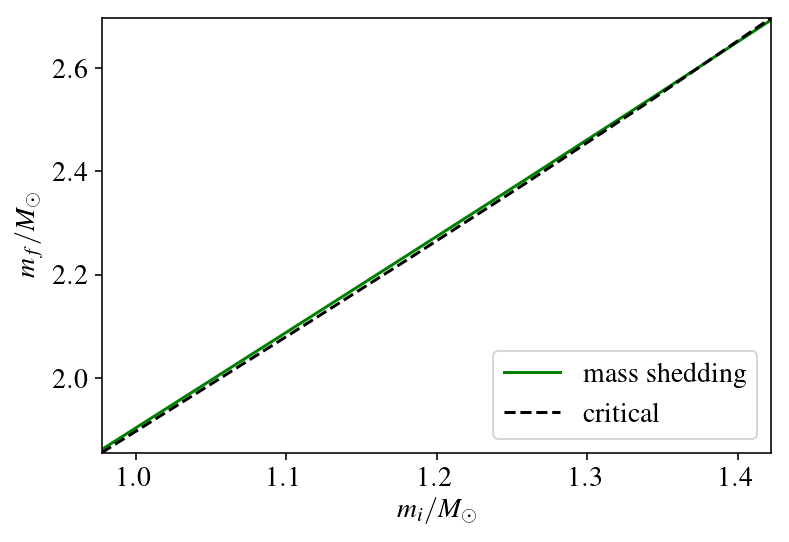

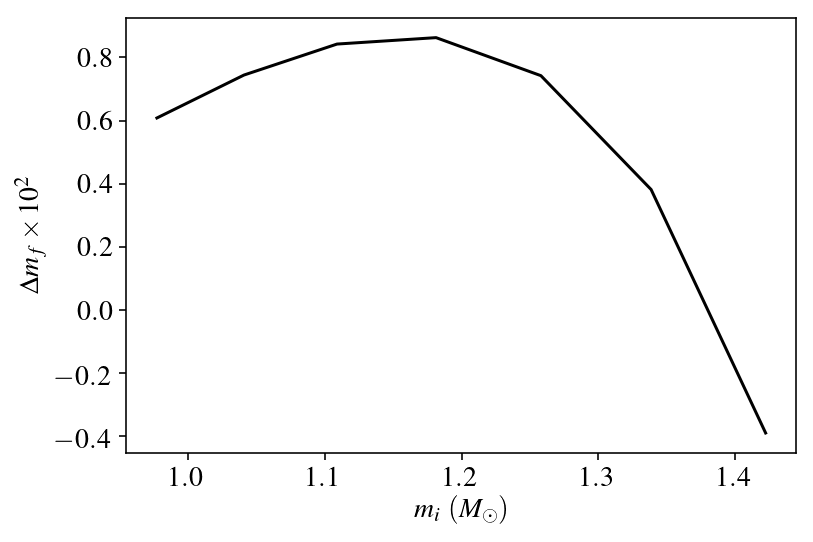

In [20]:
plt.figure()
plt.plot(m_init_0, mass_final_MS, 'g', label='mass shedding')
plt.plot(m_init_0, mnuNS, 'k--', label='critical')
plt.axis((M_data[filenames[3]][9],M_data[filenames[3]][15],mnuNS[0],mnuNS[-1]))
plt.xlabel(r'$m_i/M_{\odot}$')
plt.ylabel(r'$m_f/M_{\odot}$')
plt.legend(loc='lower right')
plt.savefig('critical_vs_mass_shedding.pdf', bbox_inches='tight')
#############################################
plt.figure()
plt.plot(m_init_0, (mass_final_MS-mnuNS)*100, 'k')
plt.xlabel(r'$m_i\ (M_{\odot})$')
plt.ylabel(r'$\Delta m_f \times 10^2$')
plt.savefig('diff_MS-critM.pdf', bbox_inches='tight')

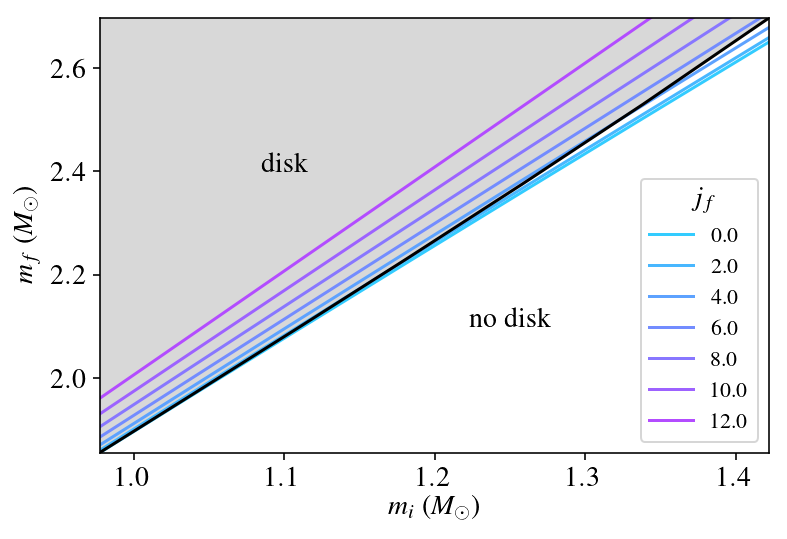

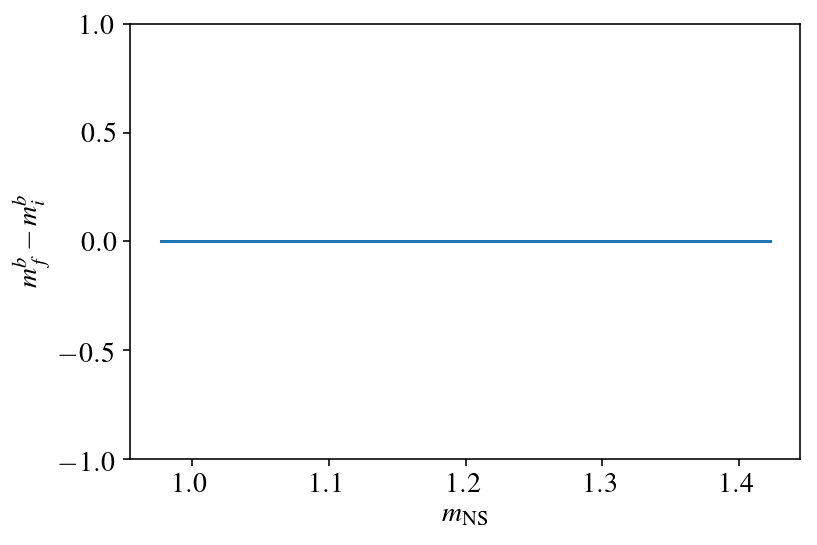

In [21]:
plt.figure()
ax = plt.axes()
ax.set_prop_cycle(cycler('color',[plt.cm.cool(i) for i in np.linspace(0.2, 0.7, len(mass_final_j))]))
for i  in np.arange(0, len(mass_final_j)):
    plt.plot(m_init, mass_final_j[i], label=j_const[i])
plt.plot(M_data[filenames[3]][9:16], mnuNS,'k')
#plt.plot(m_init_0, mass_final_MS, 'g')
#################################
plt.fill_between(M_data[filenames[3]][9:16],mnuNS,3, color='gray', alpha=0.3)
#################################
plt.text(1.25, 2.1, 'no disk', ha='center')
plt.text(1.10, 2.4, 'disk', ha='center')
#################################
plt.xlabel(r'$m_i$ ($M_{\odot}$)')
plt.ylabel(r'$m_f$ ($M_{\odot}$)')
plt.axis((M_data[filenames[3]][9],M_data[filenames[3]][15],mnuNS[0],mnuNS[-1]))
plt.legend(loc='lower right', fontsize=11, title=r'$j_f$')
plt.savefig('mnNS-mNS.pdf')
##################################
plt.figure()
plt.plot(M_data[filenames[3]][9:16], massfunc(mnuNS, j_NL3)-2*massfunc(M_data[filenames[3]][9:16],0))
plt.ylim(-1,1)
plt.xlabel(r'$m_{\rm{NS}}$')
plt.ylabel(r'$m_f^b - m^b_i$')
plt.show()
     

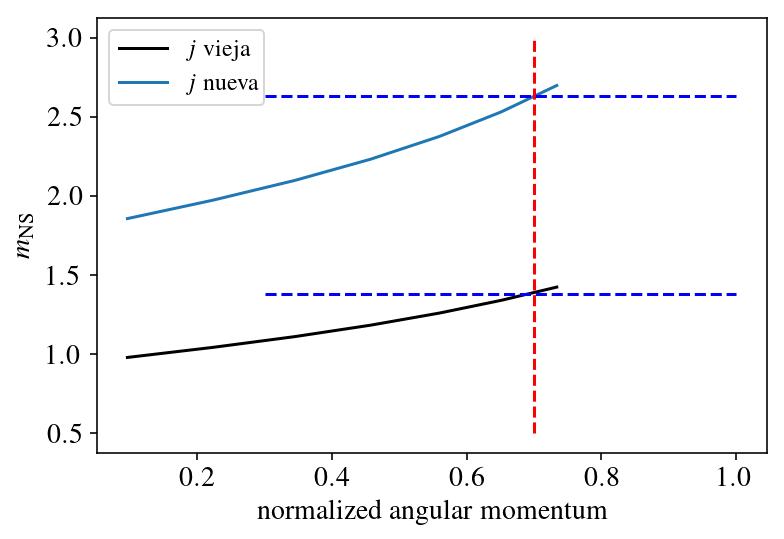

In [22]:
plt.figure()
plt.plot( j_NL3/mnuNS**2,M_data[filenames[3]][9:16], 'k-', label=r'$j$ vieja')
plt.plot(j_NL3/mnuNS**2,mnuNS, label=r'$j$ nueva')
#plt.plot(M_data[filenames[3]][9:16], jm_NL3, 'k--', label=r'$j_{rm{merger}}$')
#plt.plot(M_data[filenames[3]][9:16], jm_NL3/j_NL3, 'b', label=r'$j_{rm{merger}}/j$')
plt.plot([0.7, 0.7],[0.5, 3], 'r--')
plt.plot([0.3, 1],[1.38, 1.38], 'b--')
plt.plot([0.3, 1],[2.63, 2.63], 'b--')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel(r'$m_{\rm{NS}}$')
plt.xlabel('normalized angular momentum')
plt.savefig('angular-momentum.pdf')

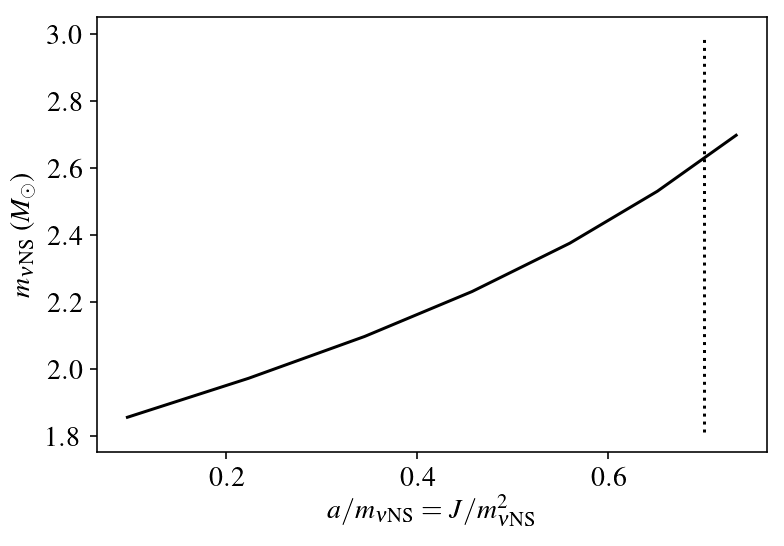

In [23]:
plt.figure()
plt.plot(j_NL3/mnuNS**2, mnuNS, 'k')
plt.plot([0.7, 0.7], [1.81, 2.99], 'k:')
plt.xlabel(r'$a/m_{\nu\rm{NS}}=J/m_{\nu\rm{NS}}^2$')
plt.ylabel(r'$m_{\nu\rm{NS}}$ ($M_{\odot}$)')
plt.savefig('mnNS-a.pdf')

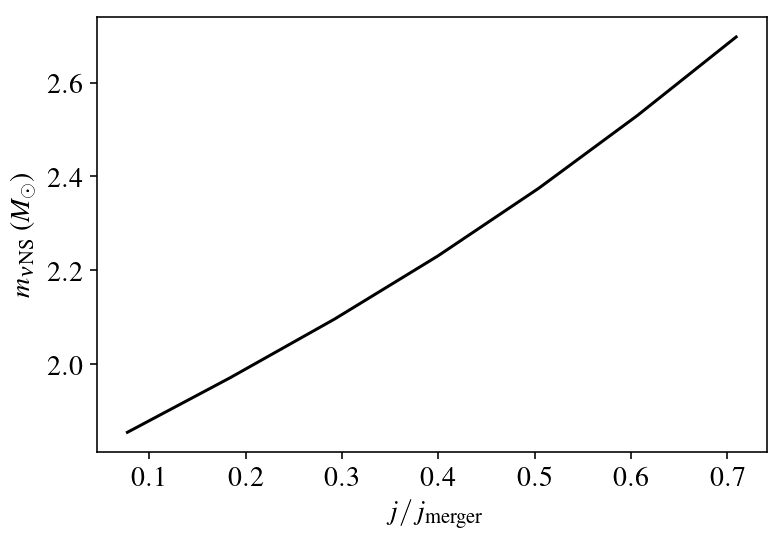

In [24]:
plt.figure()
plt.plot(j_NL3/jm_NL3, mnuNS, 'k')
#plt.plot([1, 1], [1.81, 2.99], 'k:')
plt.xlabel(r'$j/j_{\rm{merger}}$')
plt.ylabel(r'$m_{\nu\rm{NS}}$ ($M_{\odot}$)')
#plt.xlim(0.4,1.2)
plt.savefig('mnNS-jratio.pdf', bbox_inches='tight')

In [38]:
M_mass_J0_NL3 = 2.81
k_NL3 = 0.0060
l_NL3 = 1.68
j_f = np.linspace(j_NL3[0], j_NL3[-1], 15)
Mass_Secular = M_mass_J0_NL3*(1 + k_NL3*j_f)
Mass_MS_j = np.sqrt(j_f/0.7)
mass_init = np.arange(0.25,1.75,0.25)
mass_init = np.array([0.25, 1.0, 1.36])
mass_final_minitC = []
for i in np.arange(0, len(mass_init)):
    m_aux = []
    for j in np.arange(0, len(j_NL3)):
        m_aux.append(massnNS_j(mass_init[i], j_NL3[j]))
        #print m_aux
    mass_final_minitC.append(m_aux)    
mass_final_minitC = np.array(mass_final_minitC)
yticks = mass_final_minitC[:,-1]
###################
indx_nodisk_1 = np.where(mfNS_inter(j_f)>Mass_MS_j)
indx_nodisk_2 = np.where(mfNS_inter(j_f)<Mass_MS_j)
array_ndisk = np.concatenate((mfNS_inter(j_f)[indx_nodisk_1],Mass_MS_j[indx_nodisk_2]))

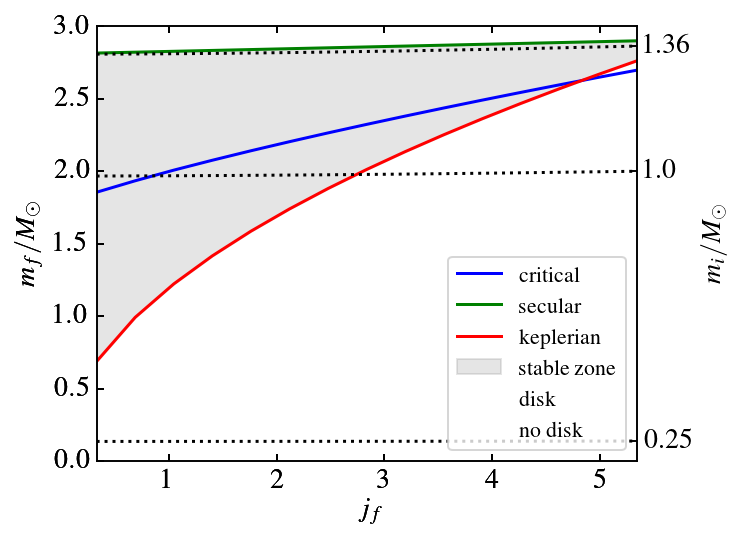

In [39]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

if 1:

    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    #par2 = host.twinx()

    #offset = 60
    #new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    #par2.axis["right"] = new_fixed_axis(loc="right",axes=par2,offset=(offset, 0))

    #par2.axis["right"].toggle(all=True)

    host.set_xlim(j_NL3[0], j_NL3[-1])
    #host.set_ylim(0, 2)
    host.set_ylim(0, 3)
    #par2.set_ylim(1, 65)
############ Labels ##################
    host.set_xlabel(r'$j_f$')
    host.set_ylabel(r'$m_f/M_{\odot}$')
    par1.set_ylabel(r'$m_i/M_{\odot}$')
    #par1.set_ylabel(r'$j_{\nu\rm{NS}}/j_{\rm{contact}}$')
    #par2.set_ylabel("Velocity")   
#########################################
    par1.set_yticks(yticks)
    par1.set_yticklabels(mass_init.astype('str'))
##########################################
    #p1, = host.plot([0, 1, 2], [0, 1, 2], label="Density")
    #p2, = par1.plot([0, 1, 2], [0, 3, 2], label="Temperature")
    #p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Velocity")
    
    p1, = host.plot(j_f, mfNS_inter(j_f), 'b' ,label='critical')
    #p1, = host.plot(J_Keplerian, Mass_Keplerian, 'r', label='Keplerian sequence')
    p1, = host.plot(j_f, Mass_Secular, 'g', label='secular')
    p1, = host.plot(j_f, Mass_MS_j, 'r', label=r'keplerian')
    for i in np.arange(0, len(mass_init)):
        p2, = par1.plot(j_NL3, mass_final_minitC[i], 'k:')
        
    #p1, = host.plot([1.81, 2.8],[0.7, 0.7], 'k:')
    #p1, = host.plot( mnuNS,j_NL3/jm_NL3, 'k--',label=r'$j_{\nu\rm{NS}}/j_{\rm{contact}}$')
    #p3, = par2.plot(mnuNS,j_NL3/mnuNS**2*2, label="Velocity")
############################################
    plt.fill_between(j_f, Mass_MS_j, Mass_Secular, color = 'gray', alpha = 0.2, label='stable zone')
    plt.fill_between(j_f, mfNS_inter(j_f), Mass_MS_j, color = 'none', hatch='/', edgecolor='k',where=Mass_MS_j< mfNS_inter(j_f), label='disk')
    plt.fill_between(j_f, array_ndisk, Mass_Secular, color = 'none', hatch='\\', edgecolor='k', label='no disk')
 
    host.legend(loc="lower right", fontsize=11)

    #host.axis["left"].label.set_color(p1.get_color())
    #par1.axis["right"].label.set_color(p2.get_color())
    #par2.axis["right"].label.set_color(p3.get_color())

    plt.draw()

    plt.savefig('mfNS-j.pdf', bbox_inches='tight')

In [27]:
def eq_Mj(jf):
    return mfNS_inter(jf)-np.sqrt(jf/0.7)
jf_max = fsolve(eq_Mj, 4.5)[0]
print jf_max, jNS_max 
print mfNS_inter(jf_max)

4.824839867 4.82414178955
2.62538156873


In [28]:
jrm1_mnNS_inter = interp1d(mnuNS,j_NL3/jm_NL3)
a7_mnNS_inter = interp1d(mnuNS,j_NL3/mnuNS**2-0.7)
#print fsolve(jrm1_mnNS_inter,2.2)[0]
mnNS_max_0 = fsolve(a7_mnNS_inter,2.2)[0]
percent_max = jrm1_mnNS_inter(mnNS_max_0)

print mnNS_max_0, percent_max

2.62881330676 0.667271878066


In [29]:
delta_j = jm_NL3-j_NL3
djdm = L_LSOfunc(mnuNS, j_NL3)
m_disk = delta_j/djdm
mb_nNS = massfunc(mnuNS, j_NL3)
for i in np.arange(0, len(djdm)):
    print "{0:.2f} & {1:.2f} & {2:.2f} \\\\".format(mb_nNS[i],  m_disk[i], m_disk[i]/mb_nNS[i])
    #print "{0:.2f}  {1:.2f} {2:.2f}".format(mnuNS[i],  m_disk[i], m_disk[i]/mnuNS[i])

2.08 & 0.63 & 0.30 \\
2.22 & 0.59 & 0.27 \\
2.38 & 0.55 & 0.23 \\
2.54 & 0.50 & 0.20 \\
2.72 & 0.44 & 0.16 \\
2.91 & 0.37 & 0.13 \\
3.11 & 0.29 & 0.09 \\


In [30]:
mass_init.astype('str')

array(['0.25', '0.5', '0.75', '1.0', '1.25', '1.5'], 
      dtype='|S32')